# Plot hsdm_07_01 plasmid
Setup

In [626]:
import os
import re
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import pandas as pd
import pysam
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord


In [3]:
cluster = '/fs/cbsuvlaminck2'
workdir = '/workdir/bmg224/manuscripts/mgefish/code/metagenomic_analysis/hybrid_assembly/plots'

os.chdir(cluster + workdir)
os.getcwd()

'/fs/cbsuvlaminck2/workdir/bmg224/manuscripts/mgefish/code/metagenomic_analysis/hybrid_assembly/plots'

In [456]:
def save_png_pdf(basename, bbox_inches="tight", dpi=1000):
    for ext in [".pdf", ".png"]:
        fn = basename + ext
        if bbox_inches:
            plt.savefig(fn, transparent=True, bbox_inches=bbox_inches, dpi=dpi)
        else:
            plt.savefig(fn, transparent=True, dpi=dpi)


def general_plot(xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    ax.spines["top"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.spines["right"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)

## Get coverage plot

Short read coverage

In [97]:
bam_fn = "../opera_ms/genomad/plasmid_seqs/contigs_gt3000_plasmid.7.bam"

samfile = pysam.AlignmentFile(bam_fn, "rb")

In [5]:
dir(samfile)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__next__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_open',
 'check_index',
 'close',
 'closed',
 'count',
 'count_coverage',
 'fetch',
 'filename',
 'format',
 'get_reference_name',
 'get_tid',
 'getrname',
 'gettid',
 'has_index',
 'head',
 'header',
 'is_bam',
 'is_cram',
 'is_open',
 'is_remote',
 'is_stream',
 'lengths',
 'mapped',
 'mate',
 'nocoordinate',
 'nreferences',
 'parse_region',
 'pileup',
 'references',
 'reset',
 'seek',
 'tell',
 'text',
 'unmapped',
 'write']

In [46]:
iter = samfile.pileup('opera_contig_10048')
coverage = []
position = []
for x in iter:
    coverage.append(x.n)
    position.append(x.pos)
print(len(coverage), len(position))

4907 4907


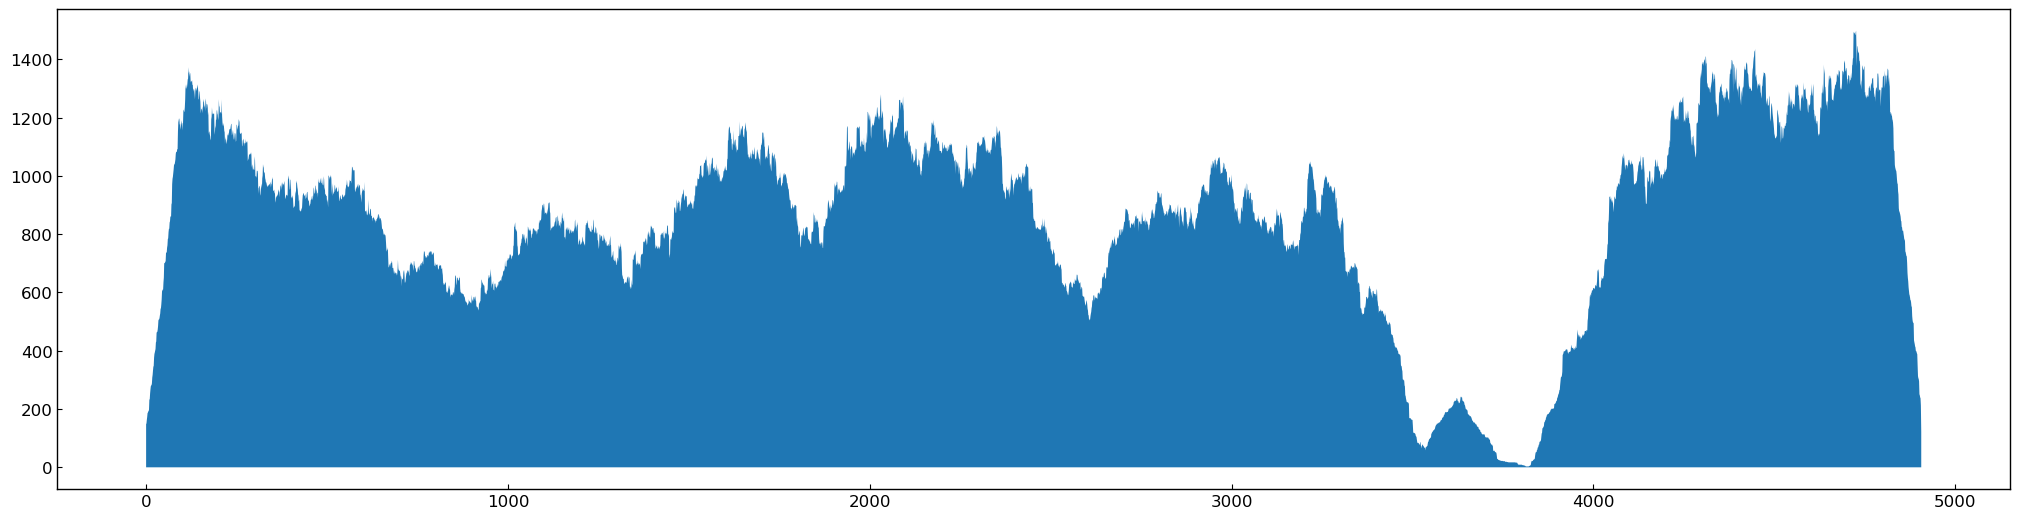

In [47]:
fig, ax = general_plot(dims=(20,5))

ax.fill_between(position, coverage)

Long read coverage

In [114]:
bam_fn = (
    "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/opera_contig_10048.aln.ont.bam"
)

samfile = pysam.AlignmentFile(bam_fn, "rb")

In [115]:
iter = samfile.pileup("opera_contig_10048")
coverage = []
position = []
for x in iter:
    coverage.append(x.n)
    position.append(x.pos)
print(len(coverage), len(position))

4907 4907


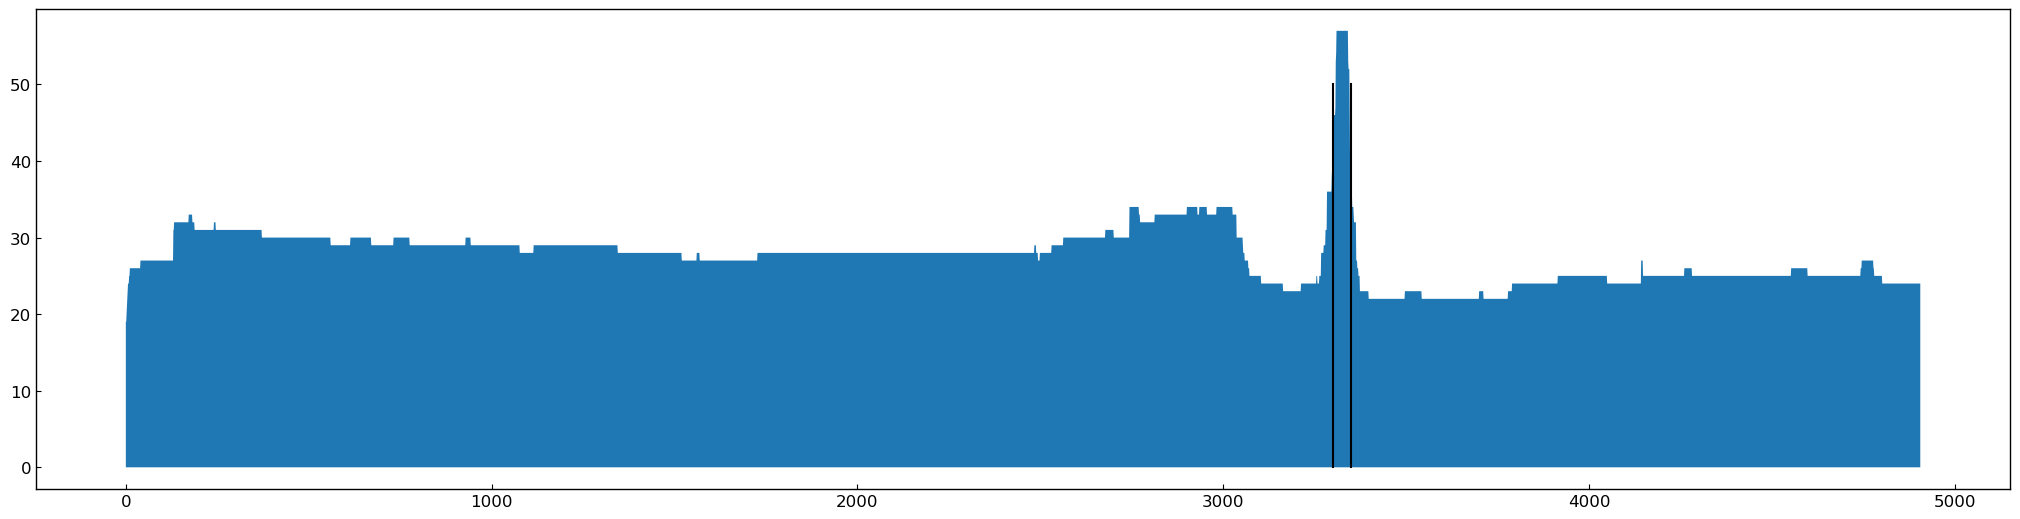

In [116]:
fig, ax = general_plot(dims=(20, 5))

ax.fill_between(position, coverage)

ax.plot([3300] * 2, [0, 50], 'k')
ax.plot([3350] * 2, [0, 50], 'k')

In [93]:
contig_fn = (
    "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/opera_contig_10048.fasta"
)

records = list(SeqIO.parse(contig_fn, 'fasta'))
seq_sub = records[0].seq[3300:3350]
seq_sub

Seq('CTCATTATACTACACAAACAAAGAAACAAACAAACAAACTAATCAATGTT')

lengths

In [98]:
length_fn = "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/opera_contig_10048.aln.ont.lengths.txt"

with open(length_fn, "r") as f:
    lines = f.readlines()
lengths = np.array(lines)

In [110]:
np.linspace(0,10,3)

array([ 0.,  5., 10.])

([<matplotlib.axis.YTick at 0x7f79f0b66fa0>,
 [Text(0, 0.0, '0.0'),
  Text(0, 1000.0, '1000.0'),
  Text(0, 2000.0, '2000.0'),
  Text(0, 3000.0, '3000.0'),
  Text(0, 4000.0, '4000.0'),
  Text(0, 5000.0, '5000.0'),
  Text(0, 6000.0, '6000.0'),
  Text(0, 7000.0, '7000.0'),
  Text(0, 8000.0, '8000.0'),
  Text(0, 9000.0, '9000.0'),
  Text(0, 10000.0, '10000.0'),
  Text(0, 11000.0, '11000.0')])

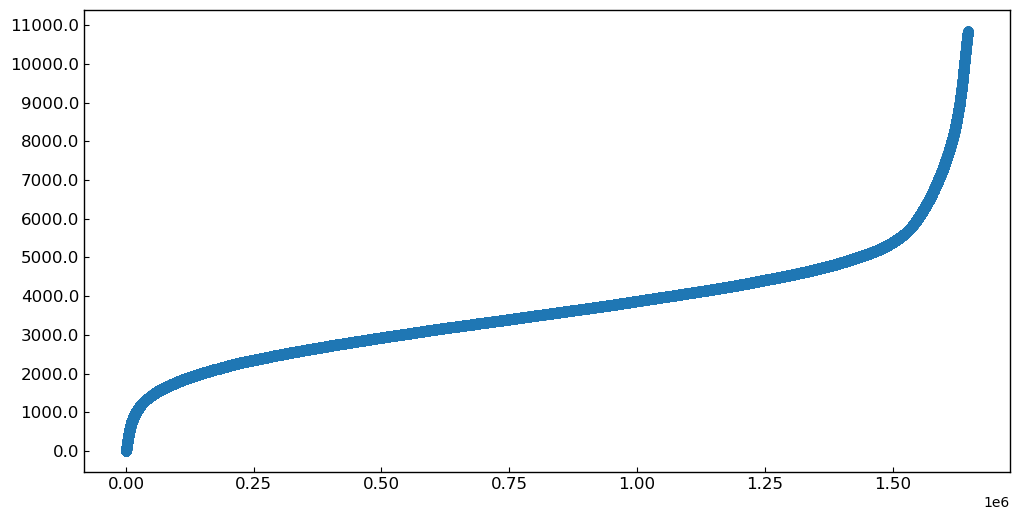

In [113]:
lengths_sub = lengths
# lengths_sub = np.random.choice(lengths, 10000, replace=False)
lengths_sort = np.sort(lengths_sub)

fig, ax = general_plot(dims=(10, 5))
ax.scatter(np.arange(len(lengths_sort)), lengths_sort)
ylim = ax.get_ylim()
plt.yticks(np.arange(0, ylim[1], 1000), np.arange(0, ylim[1], 1000))

End clipping

In [139]:
match_fracs = []
query_fracs = []
qlength = []
rlength = []
mlength = []
eclip = []
for read in samfile.fetch("opera_contig_10048"):
    l = read.inferred_length
    cigar = read.get_cigar_stats()
    tups = read.cigartuples
    l_man = 0
    for b in cigar[0]:
        l_man += b
    ec = 0
    for t in [tups[0],tups[-1]]:
        if t[0] != 0:
            ec += t[1]
    eclip.append(ec)
    qlength.append(l)
    rlength.append(l_man)
    match_fracs.append(cigar[0][0] / l_man)
    query_fracs.append(cigar[0][0] / l)
    mlength.append(cigar[0][0])

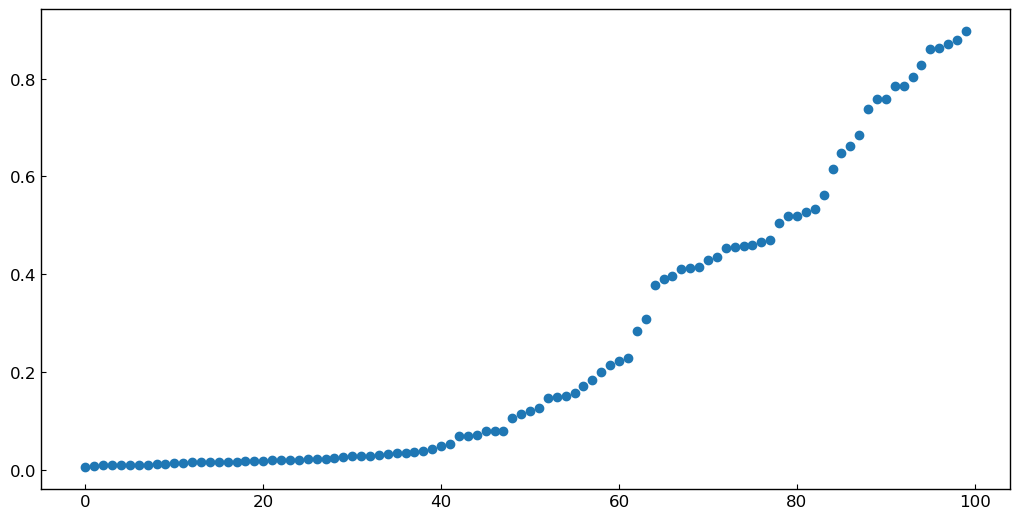

In [127]:
match_fracs_sort = np.sort(match_fracs)

fig, ax = general_plot(dims=(10, 5))
ax.scatter(np.arange(len(match_fracs_sort)), match_fracs_sort)
ylim = ax.get_ylim()
# plt.yticks(np.arange(0, ylim[1], 1000), np.arange(0, ylim[1], 1000))
ax.plot(mfrac)

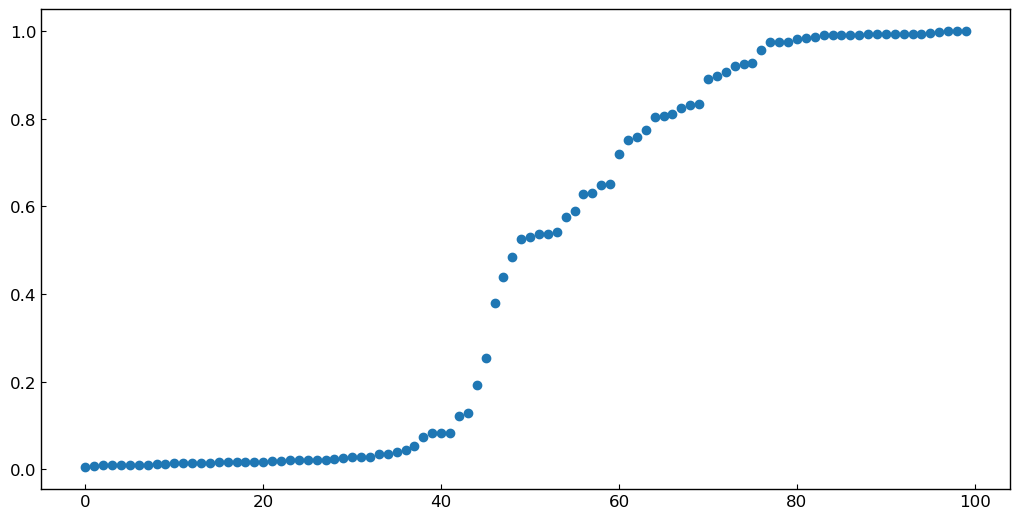

In [129]:
query_fracs_sort = np.sort(query_fracs)

fig, ax = general_plot(dims=(10, 5))
ax.scatter(np.arange(len(query_fracs_sort)), query_fracs_sort)
ylim = ax.get_ylim()
# plt.yticks(np.arange(0, ylim[1], 1000), np.arange(0, ylim[1], 1000))

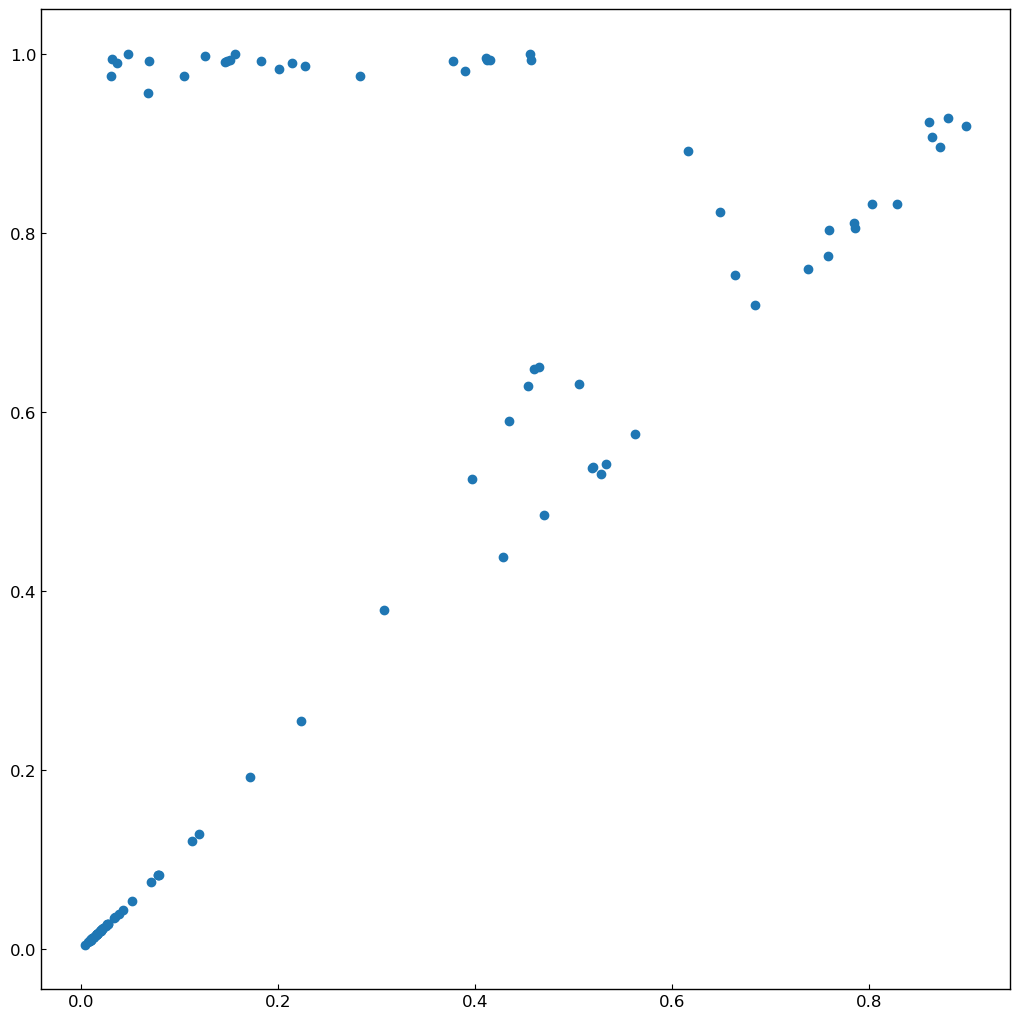

In [130]:
fig, ax = general_plot(dims = (10,10))
ax.scatter(match_fracs, query_fracs)

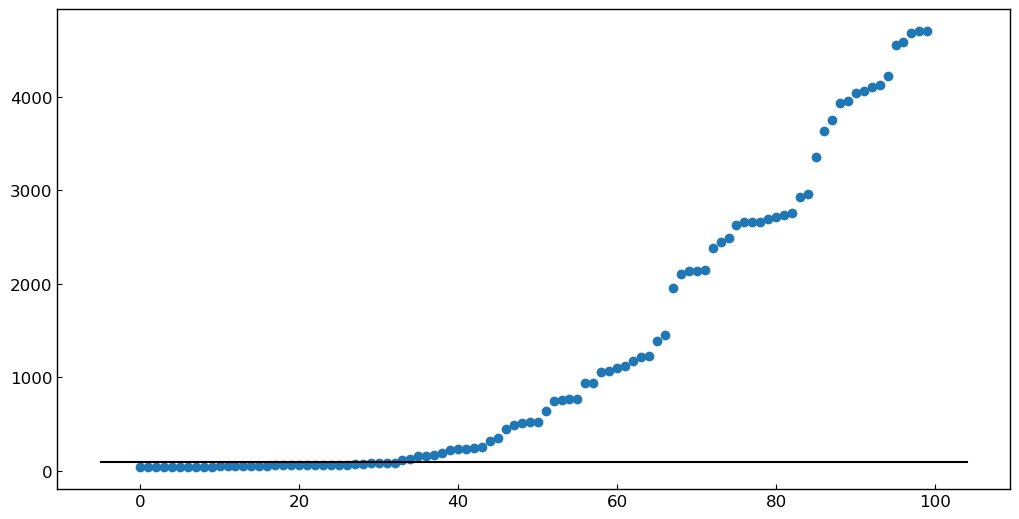

In [149]:
thresh_mlength = 100

mlength_sort = np.sort(mlength)

fig, ax = general_plot(dims=(10, 5))
ax.scatter(np.arange(len(mlength_sort)), mlength_sort)
ylim = ax.get_ylim()
xlim = ax.get_xlim()
# plt.yticks(np.arange(0, ylim[1], 1000), np.arange(0, ylim[1], 1000))

ax.plot(xlim, [thresh_mlength] * 2, 'k')

In [ ]:
fig, ax = general_plot(dims=(10, 10))
ax.scatter(rlength, mlength)
ax.plot([0,5000],[0,5000], 'k')

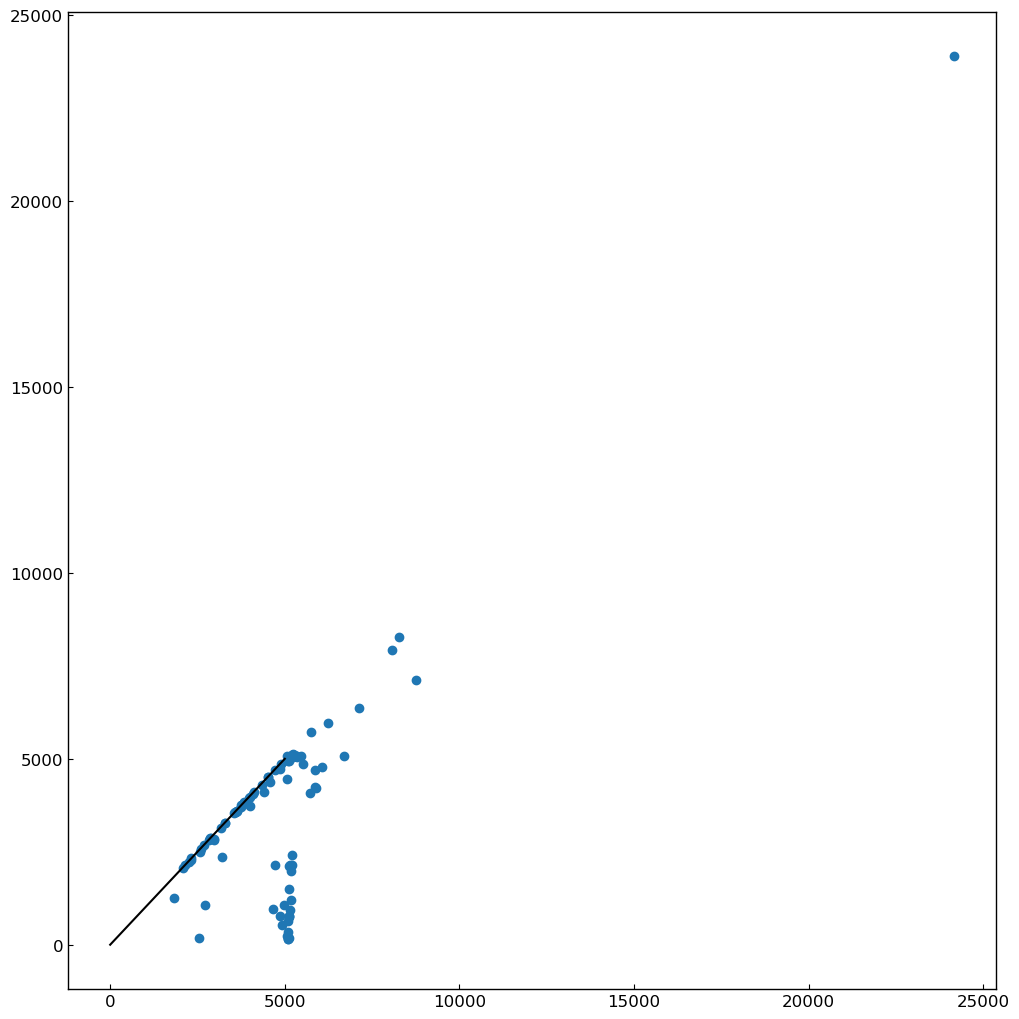

In [141]:
fig, ax = general_plot(dims=(10, 10))
ax.scatter(rlength, qlength)
ax.plot([0,5000],[0,5000], 'k')

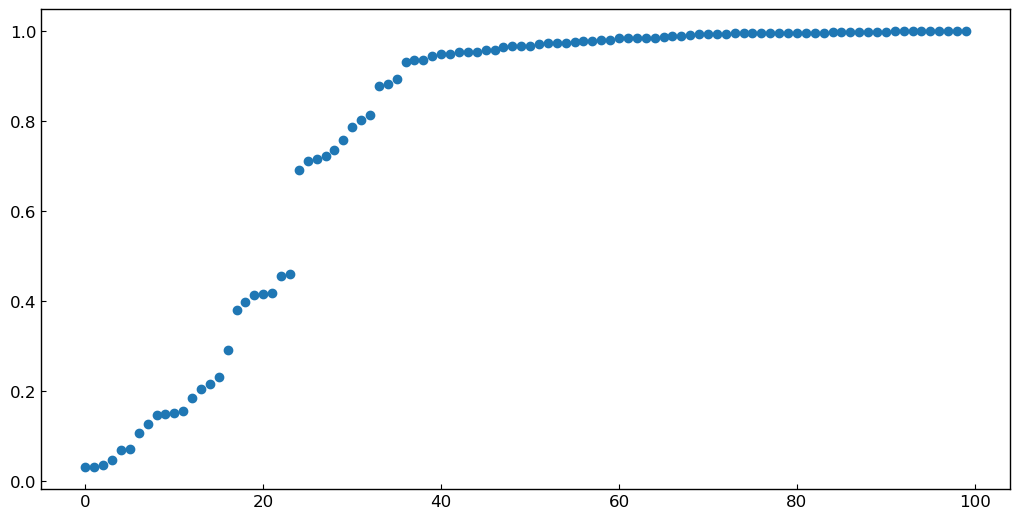

In [144]:
qlen_frac = np.array(qlength) / np.array(rlength)
qlen_frac_sort = np.sort(qlen_frac)

fig, ax = general_plot(dims=(10, 5))
ax.scatter(np.arange(len(qlen_frac_sort)), qlen_frac_sort)
ylim = ax.get_ylim()
# plt.yticks(np.arange(0, ylim[1], 1000), np.arange(0, ylim[1], 1000))

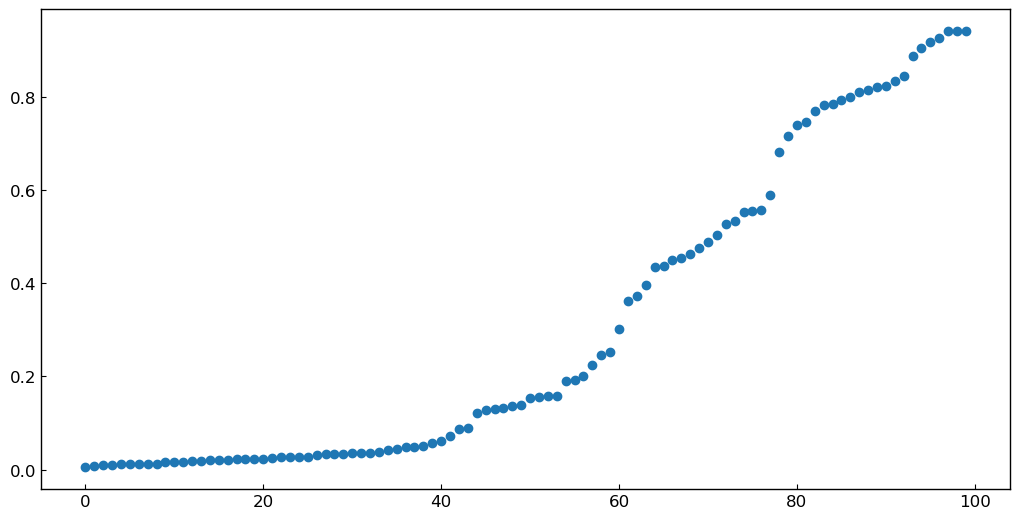

In [143]:
eclip_frac = 1 - np.array(eclip) / np.array(rlength)
eclip_frac_sort = np.sort(eclip_frac)

fig, ax = general_plot(dims=(10, 5))
ax.scatter(np.arange(len(eclip_frac_sort)), eclip_frac_sort)
ylim = ax.get_ylim()
# plt.yticks(np.arange(0, ylim[1], 1000), np.arange(0, ylim[1], 1000))

## Gen annotations

In [19]:
gff_fn = "../opera_ms/genomad/plasmid_bakta/contigs_gt3000_plasmid.gff3"
genomad_fn = (
    "../opera_ms/opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828_genomad"
)

In [94]:
contig_name = 'opera_contig_10048'

In [22]:
"opera_contig_10048	Prodigal	CDS	2023	2289	.	".split('\t')

['opera_contig_10048', 'Prodigal', 'CDS', '2023', '2289', '.', '']

In [25]:
[1,2,3][:-1]

[1, 2]

In [29]:
lines_contig = []
with open(genomad_fn, "r") as f:
    lines = f.readlines()
    for l in lines:
        if l.startswith(contig_name):
            l_list = l.split("\t")
            # l_end = l_list[-1].split(';')
            # lines_contig.append(l_list[:-1] + l_end)
            lines_contig.append(l_list)

genomad_df = pd.DataFrame(lines_contig)
genomad_df.columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,opera_contig_10048_1,1,1614,1614,-1,0.715,11,GGA/GAG/AGG,GENOMAD.030790.PP,3.44e-32,136,0,0,0,1,NA,NA,NA,NA,NA\n
1,opera_contig_10048_2,1819,2019,201,1,0.592,11,AGGA,GENOMAD.048732.PP,2.631e-18,79,0,1,0,1,NA,NA,NA,PF12958,NA\n
2,opera_contig_10048_3,2023,2289,267,1,0.607,11,AGGAG,GENOMAD.026258.PP,3.668e-40,143,0,0,0,1,NA,NA,NA,NA,NA\n
3,opera_contig_10048_4,2279,2578,300,1,0.633,11,GGAG/GAGG,GENOMAD.213714.PC,3.758e-06,46,0,0,0,1,NA,NA,NA,PF05016;COG3668;TIGR02385,Plasmid stabilization system protein ParE\n
4,opera_contig_10048_5,2657,3274,618,-1,0.712,11,AGGAGG,GENOMAD.124016.PV,2.861e-37,141,0,1,0,1,NA,NA,NA,PF11740,Plasmid replication region DNA-binding N-term\n
5,opera_contig_10048_6,4088,4711,624,1,0.603,11,GGAG/GAGG,GENOMAD.152162.PV,8.737e-53,186,0,0,0,1,NA,NA,NA,PF13730;COG5529;TIGR02812;K02565,Pyocin large subunit\n
6,opera_contig_10048_7,4807,4905,99,-1,0.687,11,None,NA,NA,NA,0,0,0,1,NA,NA,NA,NA,NA\n


In [34]:
a,b = sorted([2,1])
a,b

(1, 2)

/home/bmg224/miniconda3/envs/mag_albert/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/home/bmg224/miniconda3/envs/mag_albert/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


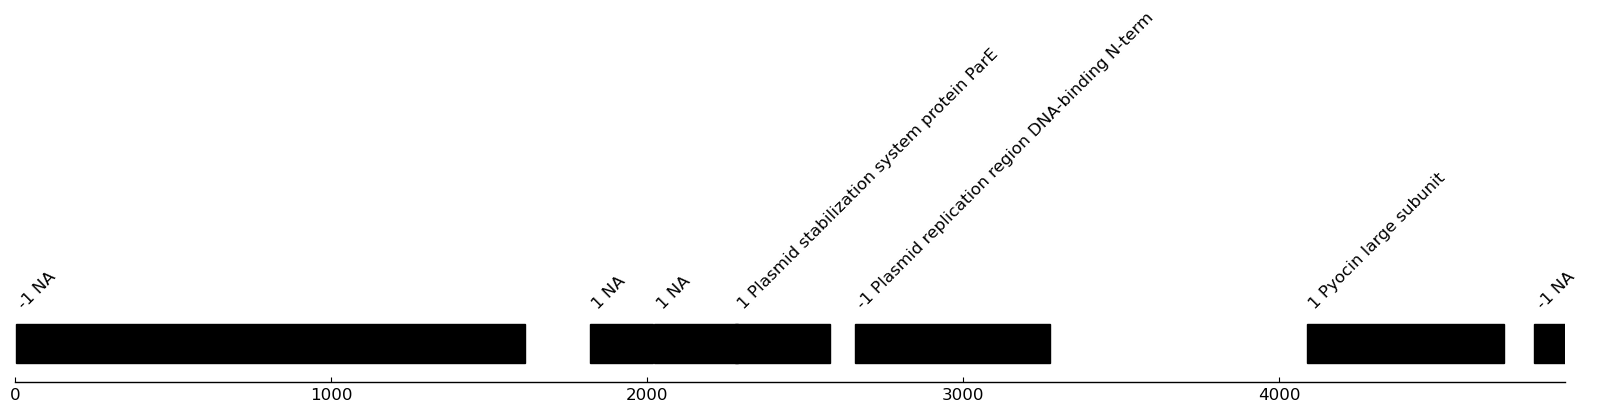

In [74]:
height = 1
displace = -0.5
displace2 = 0.6
dims = (20, 1)
ylim = (-1, 10)
ft = 12

fig, ax = general_plot(dims=dims)

ax.set_xlim(np.min(position), np.max(position))
ax.set_ylim(-1, 1)
ax.spines["top"].set_color("none")
# ax.spines["bottom"].set_color("none")
ax.spines["right"].set_color("none")
ax.spines["left"].set_color("none")
ax.set_yticks([])
# ax.fill_between(position, coverage)
# ylims = ax.get_ylim()
# disp = 0.1
# height_fac = 0.1
# displace = ylims[1]*disp
# height = ylims[1]*height_fac

for i, row in genomad_df.iterrows():
    start, end = sorted([int(s) for s in [row[1], row[2]]])
    width = end - start
    rect = patches.Rectangle(
        (start, displace), width, height, linewidth=1, edgecolor="k", facecolor="k"
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.text(start, displace2, row[4] + ' ' + row[19], fontsize=ft, rotation=45)

In [ ]:
lines_contig = []
with open(gff_fn, "r") as f:
    lines = f.readlines()
    for l in lines:
        if l.startswith(contig_name):
            l_list = l.split("\t")
            # l_end = l_list[-1].split(';')
            # lines_contig.append(l_list[:-1] + l_end)
            lines_contig.append(l_list)

bakta_df = pd.DataFrame(lines_contig)
bakta_df.columns = [
    "contig",
    "method",
    "type",
    "start",
    "end",
    "dunno",
    "strand",
    "dunno2",
    "info",
]
bakta_df

,contig,method,type,start,end,dunno,strand,dunno2,info
0,opera_contig_10048,Bakta,region,1,4907,.,+,.,ID=opera_contig_10048;Name=opera_contig_10048\n
1,opera_contig_10048,Prodigal,CDS,73,381,.,+,0,ID=IIBIEP_10290;Name=hypothetical protein;locu...
2,opera_contig_10048,Prodigal,CDS,742,1650,.,+,0,ID=IIBIEP_10295;Name=hypothetical protein;locu...
3,opera_contig_10048,Prodigal,CDS,1819,2019,.,+,0,ID=IIBIEP_10300;Name=hypothetical protein;locu...
4,opera_contig_10048,Prodigal,CDS,2023,2289,.,+,0,ID=IIBIEP_10305;Name=Plasmid stabilization pro...
5,opera_contig_10048,Prodigal,CDS,2279,2578,.,+,0,ID=IIBIEP_10310;Name=Type II toxin-antitoxin s...
6,opera_contig_10048,Prodigal,CDS,2657,3274,.,-,0,ID=IIBIEP_10315;Name=hypothetical protein;locu...
7,opera_contig_10048,Prodigal,CDS,4088,4711,.,+,0,ID=IIBIEP_10320;Name=Helix-turn-helix domain-c...


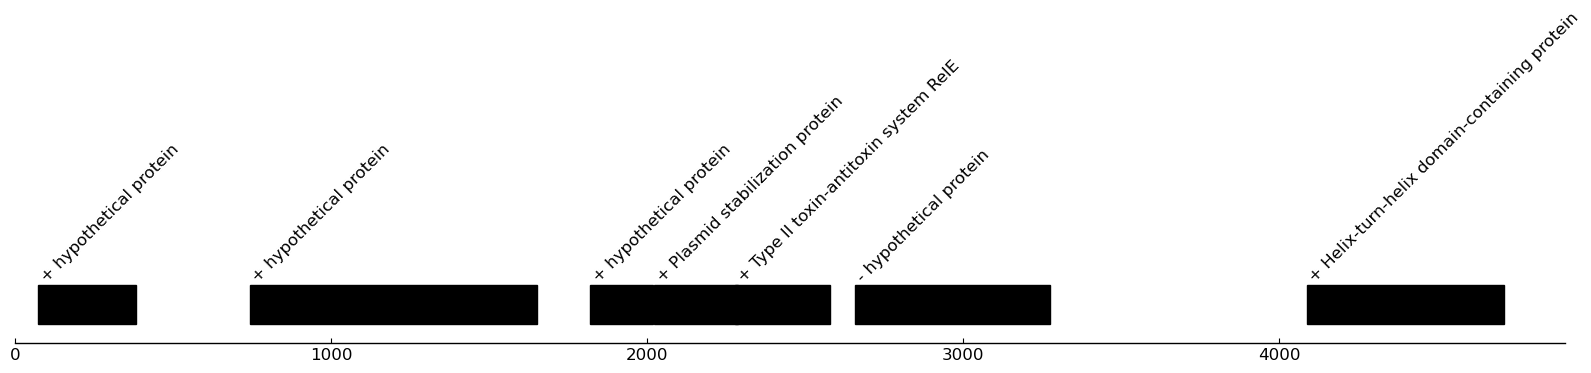

In [83]:
height = 1
displace = -0.5
displace2 = 0.6
dims = (20, 1)
ylim = (-1, 10)
ft = 12

fig, ax = general_plot(dims=dims)

ax.set_xlim(np.min(position), np.max(position))
ax.set_ylim(-1, 1)
ax.spines["top"].set_color("none")
# ax.spines["bottom"].set_color("none")
ax.spines["right"].set_color("none")
ax.spines["left"].set_color("none")
ax.set_yticks([])
# ax.fill_between(position, coverage)
# ylims = ax.get_ylim()
# disp = 0.1
# height_fac = 0.1
# displace = ylims[1]*disp
# height = ylims[1]*height_fac

for i, row in bakta_df[1:].iterrows():
    start, end = sorted([int(s) for s in [row['start'], row['end']]])
    width = end - start
    rect = patches.Rectangle(
        (start, displace), width, height, linewidth=1, edgecolor="k", facecolor="k"
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
    name = re.findall('(?<=Name=)[a-zA-Z0-9\s\-]+',row['info'])[0]
    ax.text(start, displace2, row['strand'] + ' ' + name, fontsize=ft, rotation=45)

# Flye ont assembly
short reads

In [384]:
contig_name = "contig_89828"

In [191]:
bam_fn = "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828.bt2multi.illumina.patient7.bam"
samfile = pysam.AlignmentFile(bam_fn, "rb")

In [192]:
iter = samfile.pileup(contig_name, stepper='nofilter')
coverage = []
position = []
for x in iter:
    coverage.append(x.n)
    position.append(x.pos)
print(len(coverage), len(position))

9865 9865


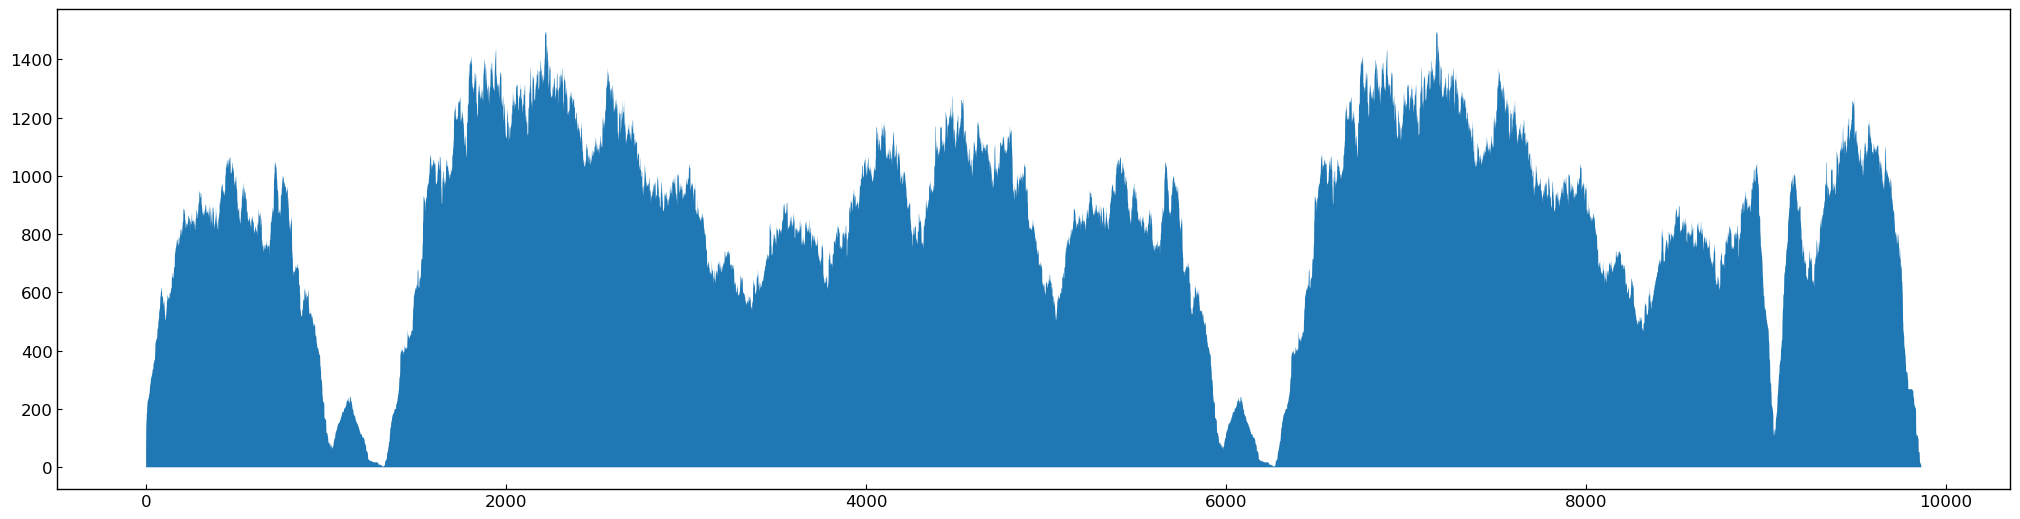

In [193]:
fig, ax = general_plot(dims=(20, 5))

ax.fill_between(position, coverage)

In [199]:
pos_range = [158, 5106]

contig_fn = (
    "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828.fasta"
)

records = list(SeqIO.parse(contig_fn, "fasta"))


print(records[0][pos_range[0] : pos_range[0] + 100].seq)
print(records[0][pos_range[1] : pos_range[1] + 100].seq)
print(coverage[pos_range[0] : pos_range[0] + 100])
print(coverage[pos_range[1] : pos_range[1] + 100])

CAGCCCTGGTCACCAGCCCCCTTGCCGCCCTTGCGTCGGGGCTGCTGCTGATCCAGCTCTCCGCGCGCCAAGGCTGCCATCAGCGCAGCCTGCGACTCCT
CAGCCCTGGTCACCAGCCCCCTTGCCGCCCTTGCGTCGGGGCTGCTGCTGATCCAGCTCTCCGCGCGCCAAGGCTGCCATCAGCGCAGCCTGCGACTCCT
[687, 688, 722, 735, 737, 754, 732, 753, 753, 759, 773, 753, 770, 782, 777, 783, 766, 769, 781, 783, 794, 778, 764, 759, 766, 763, 770, 790, 788, 784, 787, 794, 798, 813, 816, 818, 798, 796, 805, 817, 816, 818, 805, 812, 823, 830, 843, 843, 842, 871, 888, 887, 884, 887, 884, 882, 877, 870, 868, 844, 849, 847, 823, 823, 820, 833, 840, 834, 838, 831, 833, 834, 839, 841, 820, 845, 848, 861, 863, 859, 868, 851, 853, 855, 854, 854, 808, 846, 840, 844, 847, 838, 834, 835, 834, 872, 851, 879, 843, 845]
[687, 688, 722, 735, 737, 754, 732, 753, 753, 759, 773, 753, 770, 782, 777, 783, 766, 769, 781, 783, 794, 778, 764, 759, 766, 763, 770, 790, 788, 784, 787, 794, 798, 813, 816, 818, 798, 796, 805, 817, 816, 818, 805, 812, 823, 830, 843, 843, 842, 871, 888, 887, 884, 887, 884, 882, 877, 870, 868, 8

In [605]:
print(np.diff(pos_range))

[4948]


In [ ]:
coverage_sub = coverage[pos_range[0] : pos_range[1]]
positions_sub = np.arange(len(coverage_sub))
coverage_sub[0:10]

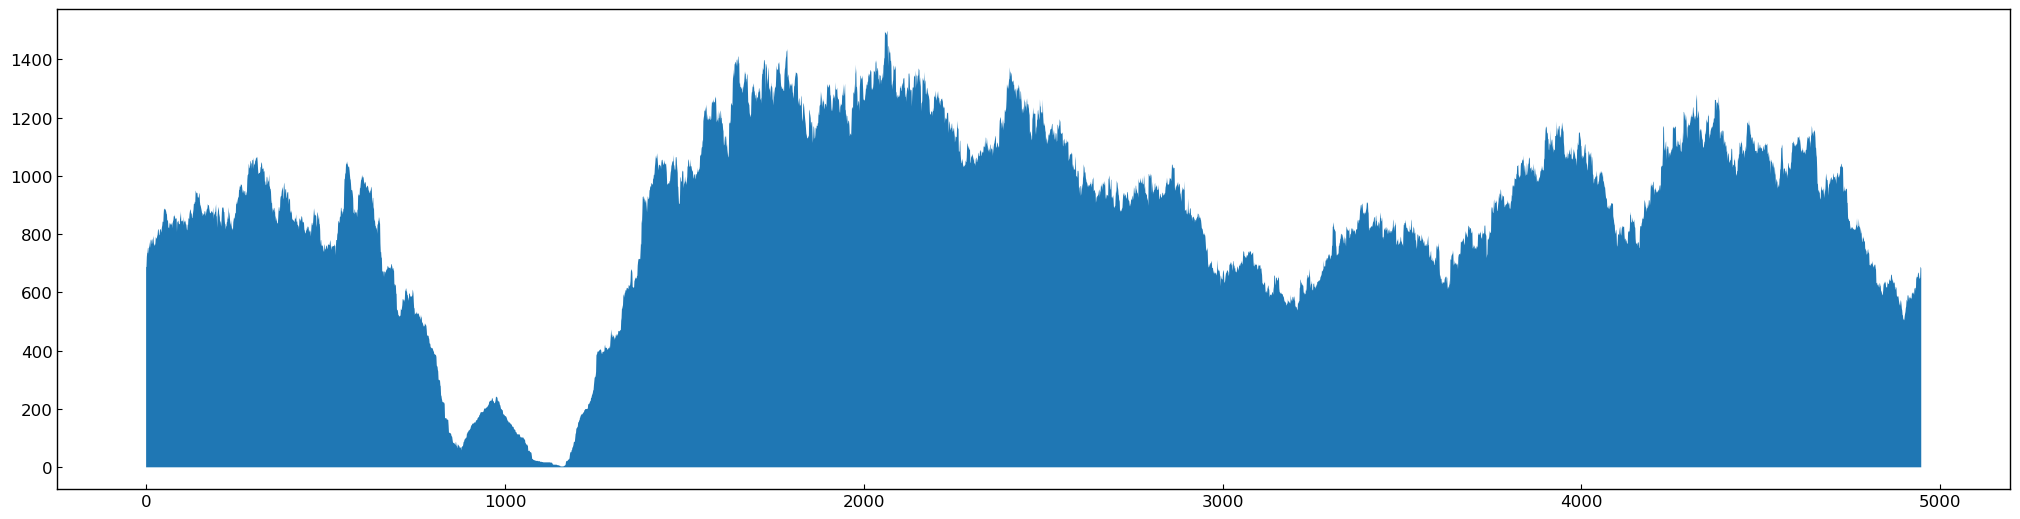

In [204]:
fig, ax = general_plot(dims=(20, 5))

ax.fill_between(positions_sub, coverage_sub)

long read coverage

In [458]:
bam_fn = "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828_triple_oneline.bwa_multi.ont.bam"

samfile = pysam.AlignmentFile(bam_fn, "rb")

iter = samfile.pileup(contig_name, stepper="nofilter")
coverage_ont = []
position_ont = []
for x in iter:
    coverage_ont.append(x.n)
    position_ont.append(x.pos)
print(len(coverage_ont), len(position_ont))

samfile.close()

14844 14844


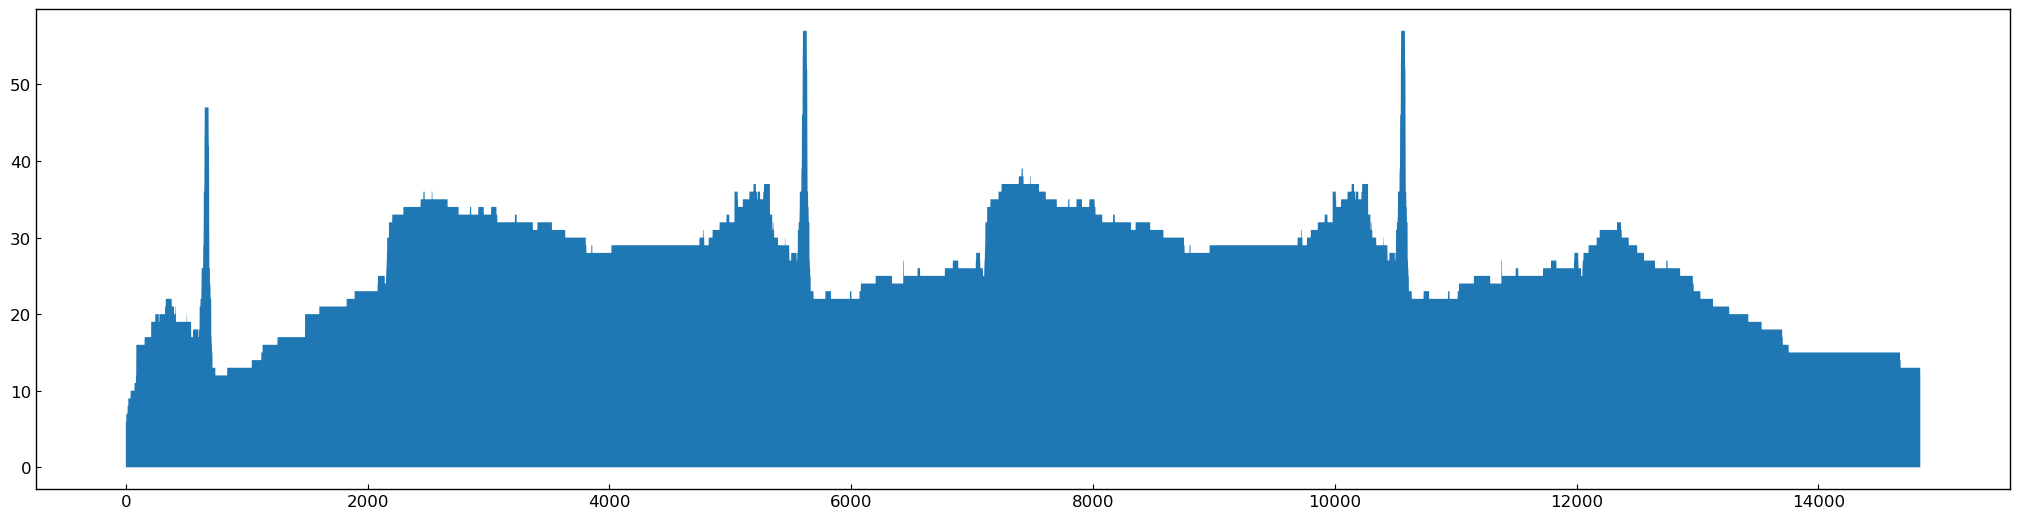

In [460]:
fig, ax = general_plot(dims=(20, 5))

ax.fill_between(position_ont, coverage_ont)

# ax.plot([3300] * 2, [0, 50], "k")
# ax.plot([3350] * 2, [0, 50], "k")

In [461]:
# Get alignement info
samfile = pysam.AlignmentFile(bam_fn, "rb")
qlength = []
rlength = []
mlength = []
eclip = []
for read in samfile.fetch(contig_name):
    l = read.inferred_length  # aligned length
    cigar = read.get_cigar_stats()
    tups = read.cigartuples
    l_man = 0
    for b in cigar[0]:
        l_man += b  # total read length
    ec = 0
    for t in [tups[0], tups[-1]]:
        if t[0] != 0:
            ec += t[1]  # end clip length
    eclip.append(ec)
    qlength.append(l)
    rlength.append(l_man)
    mlength.append(cigar[0][0])  # match length

samfile.close()

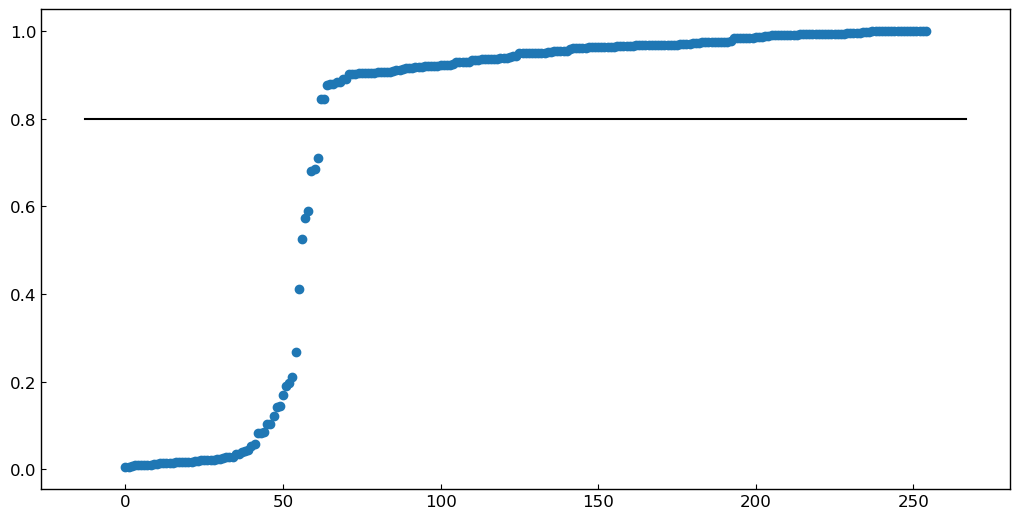

In [471]:
# pick threshold filter out reads with lots of internal mismatches
thresh_m_q = 0.8

m_q_frac = np.array(mlength) / np.array(qlength)

lsort = np.sort(m_q_frac)

fig, ax = general_plot(dims=(10, 5))
ax.scatter(np.arange(len(lsort)), lsort)
ylim = ax.get_ylim()
xlim = ax.get_xlim()
# plt.yticks(np.arange(0, ylim[1], 1000), np.arange(0, ylim[1], 1000))

ax.plot(xlim, [thresh_m_q] * 2, "k")

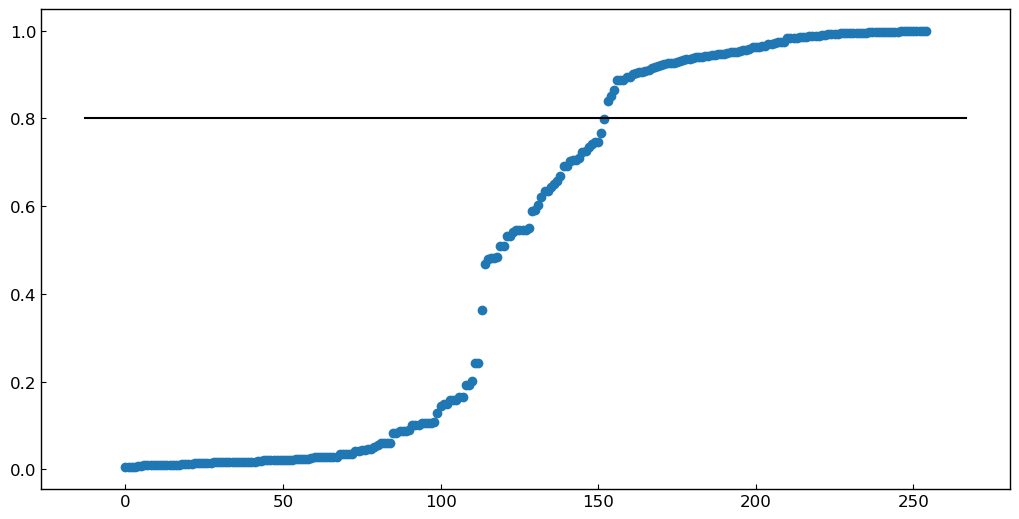

In [478]:
# pick threshold filter reads with large end clips
thresh_q_r = 0.8

q_r_frac = np.array(qlength) / np.array(rlength)

lsort = np.sort(q_r_frac)

fig, ax = general_plot(dims=(10, 5))
ax.scatter(np.arange(len(lsort)), lsort)
ylim = ax.get_ylim()
xlim = ax.get_xlim()
# plt.yticks(np.arange(0, ylim[1], 1000), np.arange(0, ylim[1], 1000))

ax.plot(xlim, [thresh_q_r] * 2, "k")

In [479]:
# write new filtered bam file
out_bam_fn = "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828_triple_oneline.bwa_multi.ont.filt.bam"

bam = pysam.AlignmentFile(bam_fn)
obam = pysam.AlignmentFile(out_bam_fn, "wb", template=bam)
for read in bam.fetch(contig_name):
    q = read.inferred_length
    cigar = read.get_cigar_stats()
    m = cigar[0][0]
    r = 0
    for b in cigar[0]:
        r += b
    if m / q > thresh_m_q:
        if q / r > thresh_q_r:
            obam.write(read)
bam.close()
obam.close()

Now run this in the command line:

```
samtools index flye_contig_89828_triple_oneline.bwa_multi.ont.filt.bam
```

and wait for a few minutes (was giving me a 'no index' even after it was generated)

In [480]:
samfile = pysam.AlignmentFile(out_bam_fn, "rb")
iter = samfile.pileup(contig_name, stepper="nofilter")
coverage_ont = []
position_ont = []
for x in iter:
    coverage_ont.append(x.n)
    position_ont.append(x.pos)
print(len(coverage_ont), len(position_ont))

14844 14844


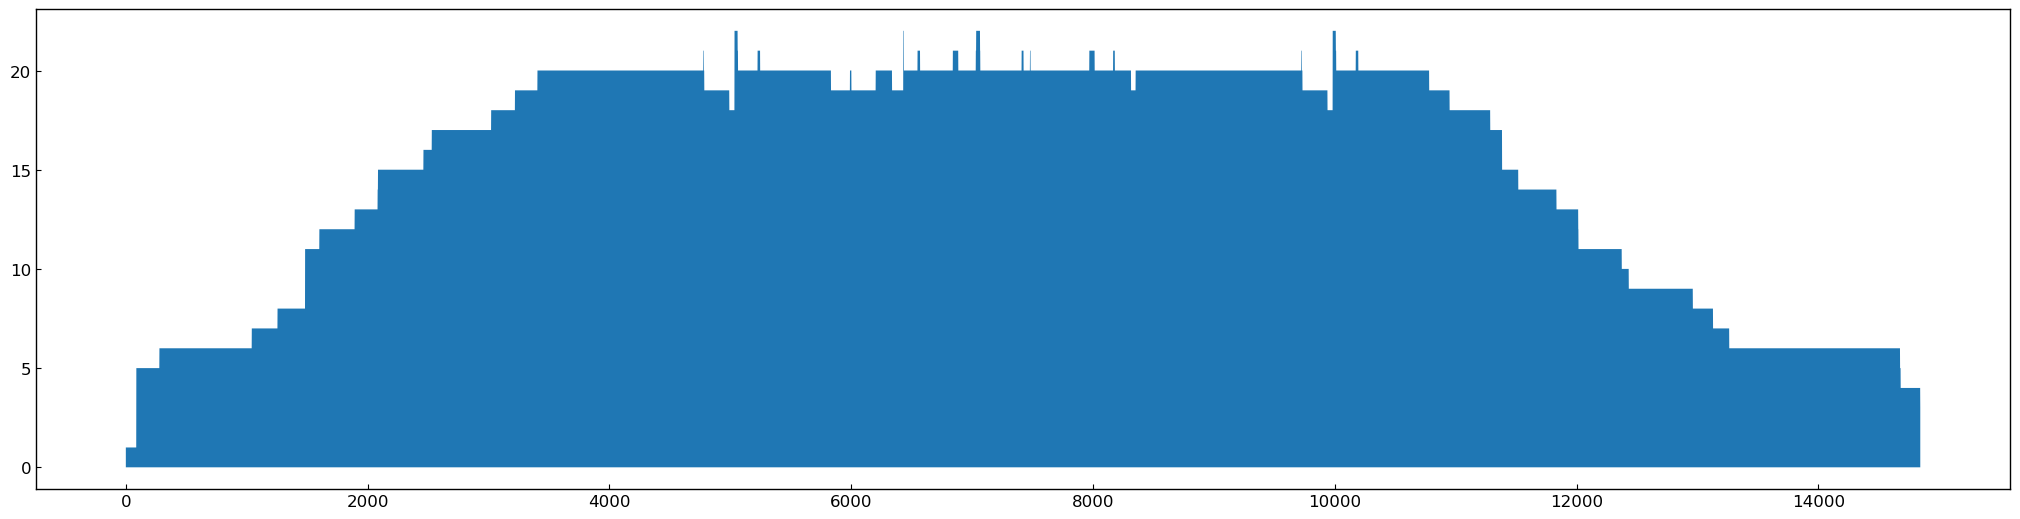

In [481]:
fig, ax = general_plot(dims=(20, 5))

ax.fill_between(position_ont, coverage_ont)

In [482]:
s_ont = pos_range[1] - pos_range[0]
e_ont = s_ont * 2
coverage_ont_sub = np.array(coverage_ont[s_ont: e_ont])
positions_ont_sub = np.arange(len(coverage_ont_sub))
coverage_ont_sub[0:10]

array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19])

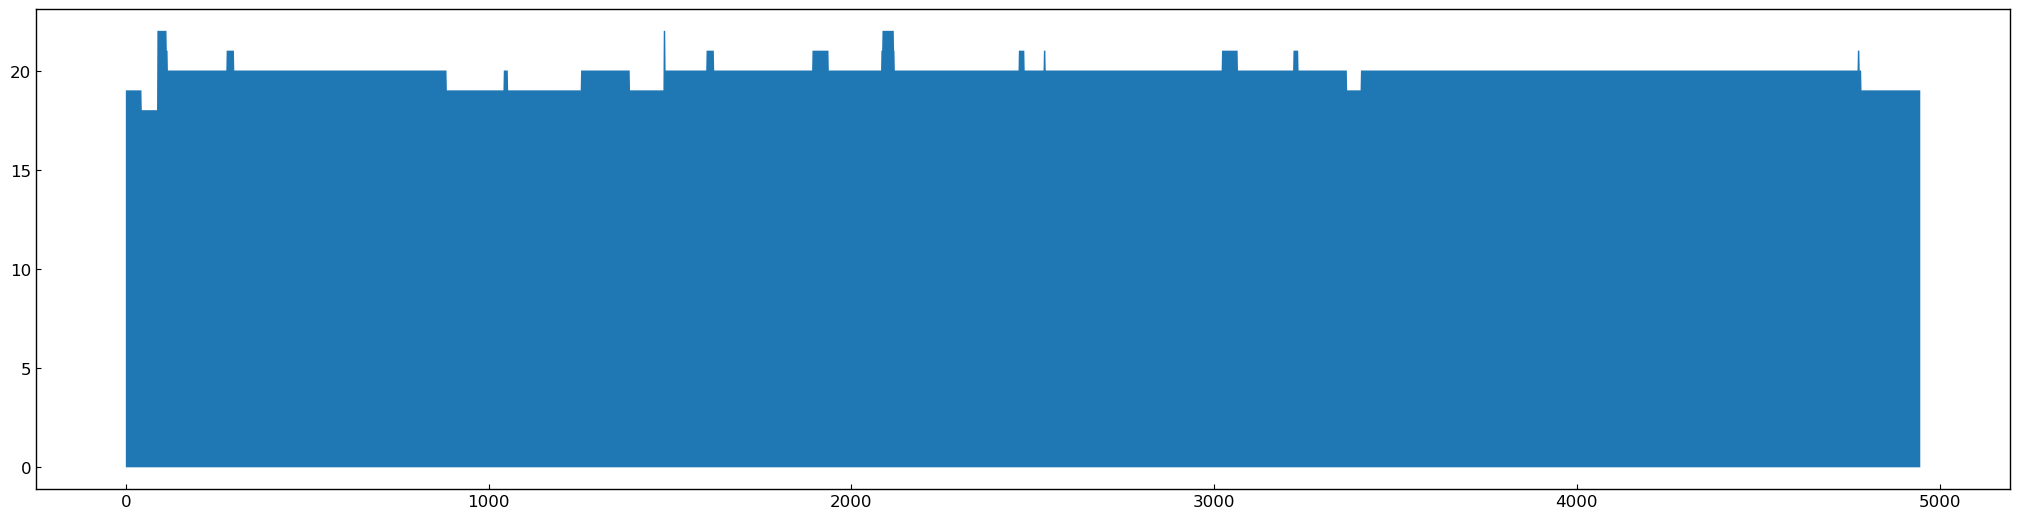

In [483]:
fig, ax = general_plot(dims=(20, 5))

ax.fill_between(positions_ont_sub, coverage_ont_sub)

### GC bias

In [562]:
contig_fn = (
    "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828.fasta"
)

records = list(SeqIO.parse(contig_fn, "fasta"))
# sequence = records[0].seq
sequence = records[0].seq[pos_range[0] : pos_range[1]]
sequence, len(sequence)

(Seq('CAGCCCTGGTCACCAGCCCCCTTGCCGCCCTTGCGTCGGGGCTGCTGCTGATCC...CCT'), 4948)

In [544]:
sequence[-w:], sequence[:w]

(Seq('GACTCCGCCT'), Seq('CAGCCCTGGT'))

In [719]:
window = 100

w = window // 2
sequence_pad = sequence[-w:] + sequence + sequence[:w]

gc_fracs = []
for i in range(len(sequence)):
    s_w = sequence_pad[i: i + window]
    gc = len(re.findall("[GCgc]", str(s_w)))
    gc_fracs.append(gc / window)

len(gc_fracs)

4948

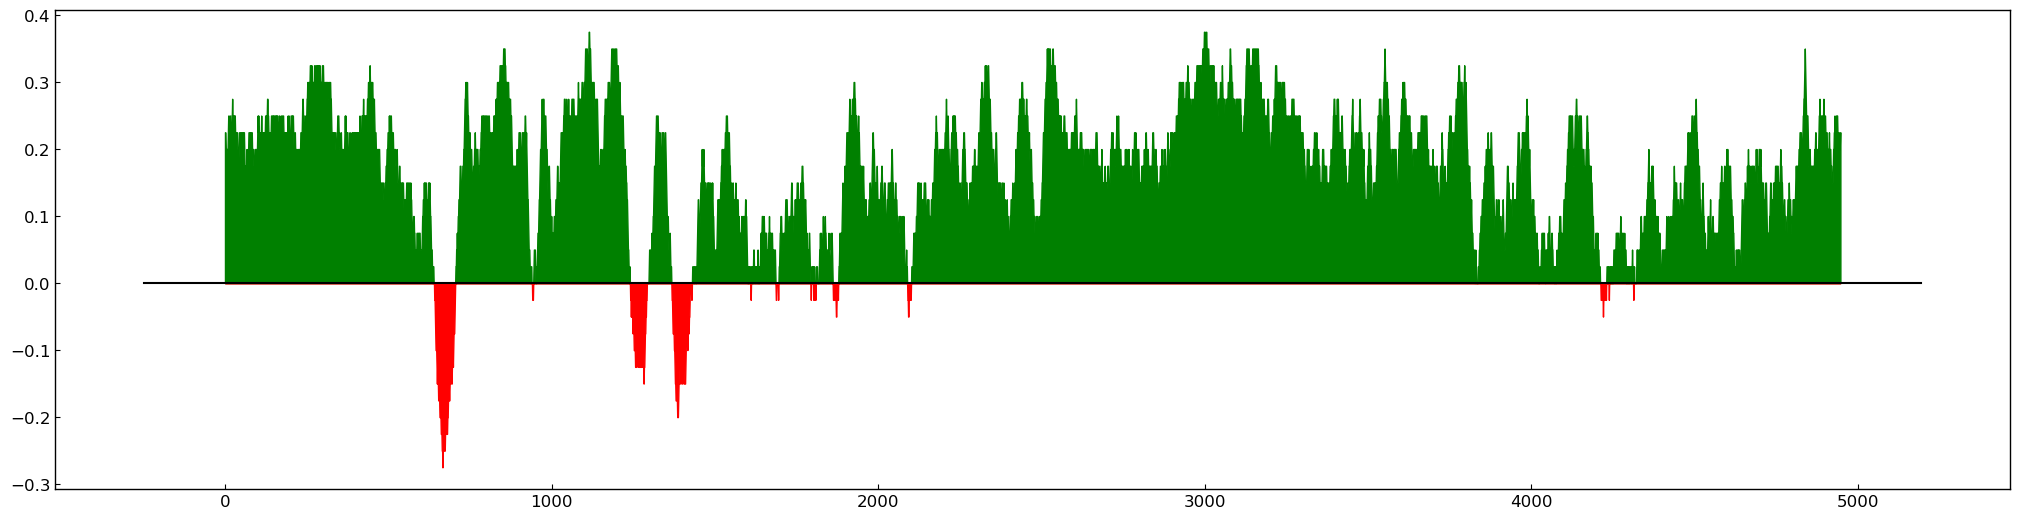

In [710]:
fig, ax = general_plot(dims=(20, 5))
gc_bias = np.array(gc_fracs) - 0.5
gc_bias_pos = gc_bias * (gc_bias > 0)
gc_bias_neg = gc_bias * (gc_bias < 0)
ax.fill_between(
    np.arange(len(gc_bias_pos)), np.zeros(len(gc_bias_pos)), gc_bias_pos, color="g"
)
ax.fill_between(
    np.arange(len(gc_bias_neg)), np.zeros(len(gc_bias_neg)), gc_bias_neg, color="r"
)
xlim = ax.get_xlim()
ax.plot(xlim, [0, 0], "k")

In [575]:
window = 50

w = window // 2
sequence_pad = sequence[-w:] + sequence + sequence[:w]

gc_skew = []
for i in range(len(sequence)):
    s_w = sequence_pad[i : i + window]
    g = len(re.findall("[Gg]", str(s_w)))
    c = len(re.findall("[Cc]", str(s_w)))
    gc_skew.append((g - c) / (g + c))

len(gc_skew)

4948

In [721]:
850 - 574

276

In [715]:
lines = [850,1150]

(0.0, 4948.0)

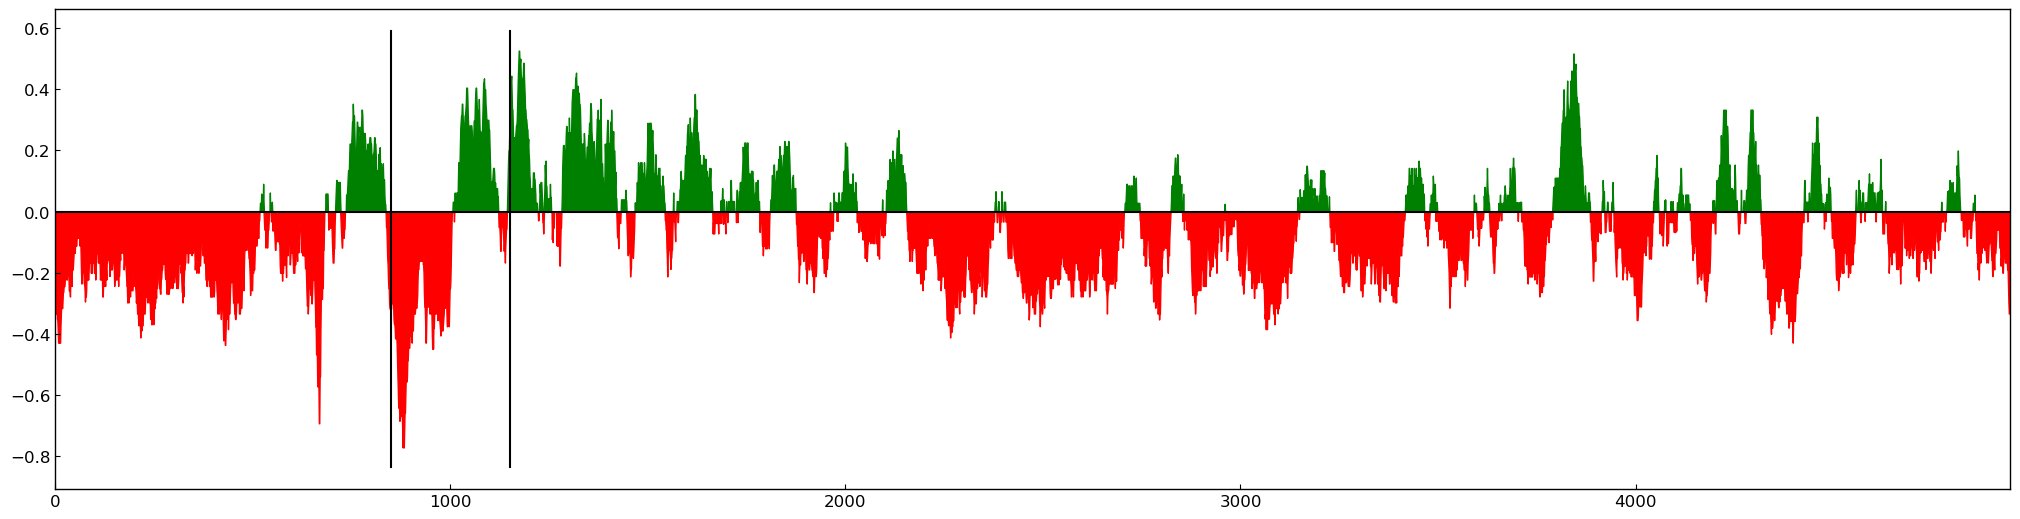

In [716]:
fig, ax = general_plot(dims=(20, 5))
# gc_bias = np.array(gc_fracs) - 0.5
gc_skew = np.array(gc_skew)
gc_skew_pos = gc_skew * (gc_skew > 0)
gc_skew_neg = gc_skew * (gc_skew < 0)
ax.fill_between(
    np.arange(len(gc_skew_pos)), np.zeros(len(gc_skew_pos)), gc_skew_pos, color="g"
)
ax.fill_between(
    np.arange(len(gc_skew_neg)), np.zeros(len(gc_skew_neg)), gc_skew_neg, color="r"
)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, [0, 0], "k")
ax.plot([lines[0]]*2,ylim, 'k')
ax.plot([lines[1]]*2,ylim, 'k')
ax.set_xlim(0,s_ont)

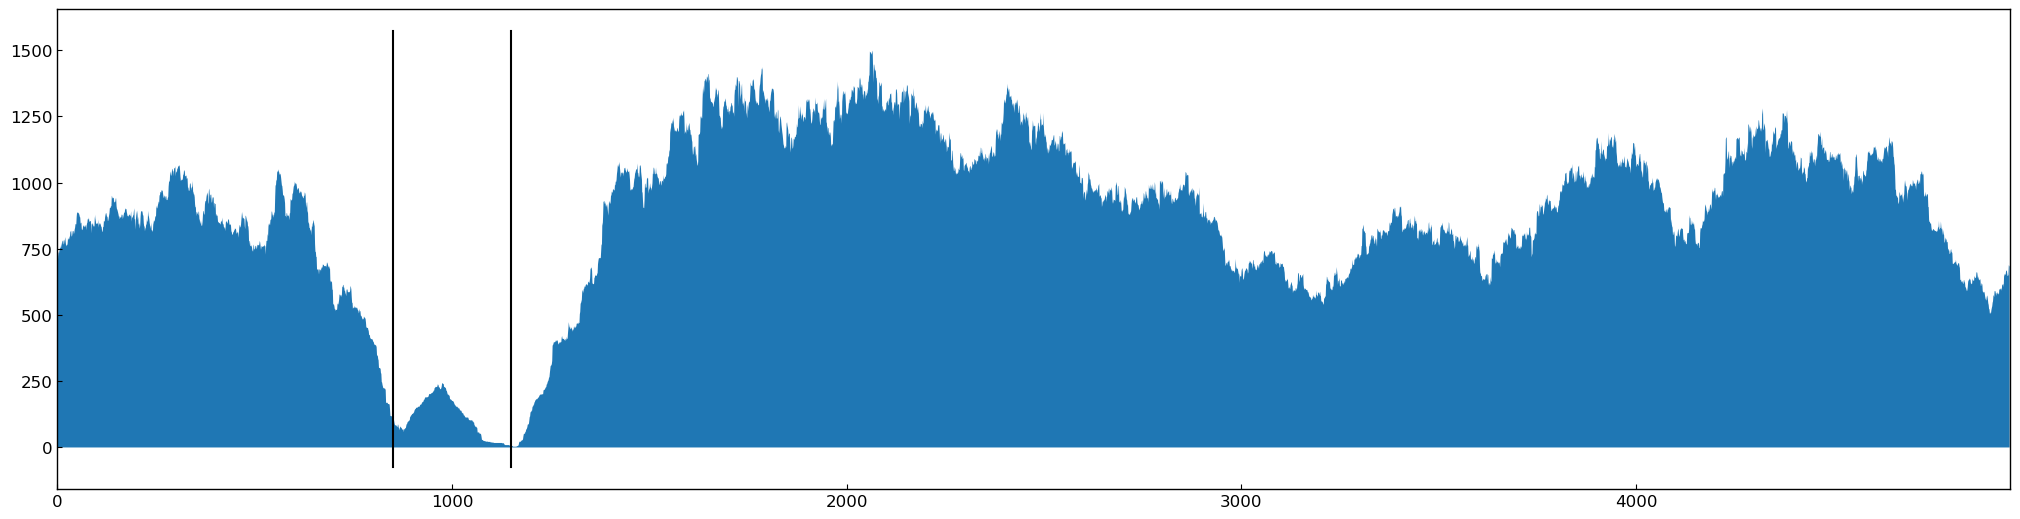

In [717]:
fig, ax = general_plot(dims=(20, 5))

ax.fill_between(positions_sub, coverage_sub)
ax.set_xlim(0,s_ont)
ylim = ax.get_ylim()
ax.plot([lines[0]]*2, ylim, 'k')
ax.plot([lines[1]]*2, ylim, 'k')


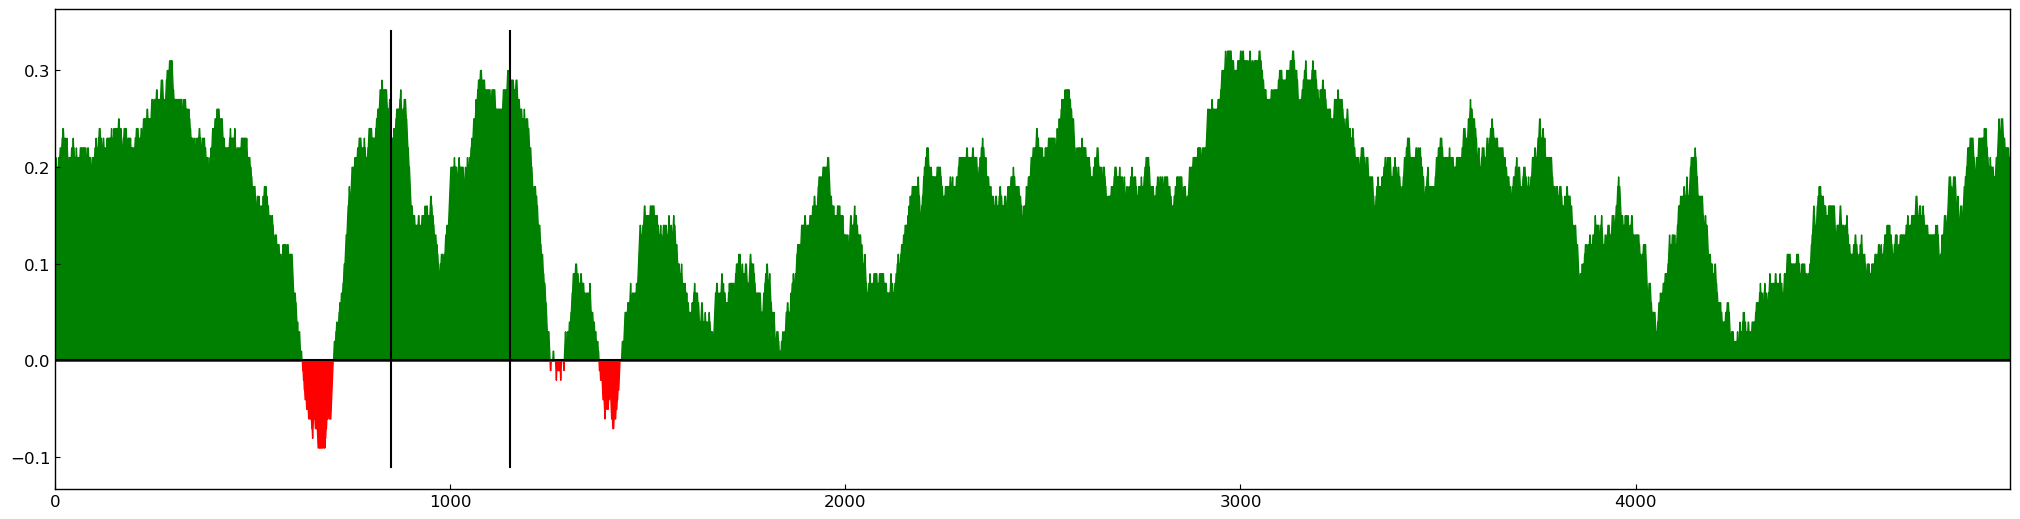

In [720]:
fig, ax = general_plot(dims=(20, 5))
gc_bias = np.array(gc_fracs) - 0.5
gc_bias_pos = gc_bias * (gc_bias > 0)
gc_bias_neg = gc_bias * (gc_bias < 0)
ax.fill_between(
    np.arange(len(gc_bias_pos)), np.zeros(len(gc_bias_pos)), gc_bias_pos, color="g"
)
ax.fill_between(
    np.arange(len(gc_bias_neg)), np.zeros(len(gc_bias_neg)), gc_bias_neg, color="r"
)
xlim = ax.get_xlim()
ax.plot(xlim, [0, 0], "k")
ax.set_xlim(0,s_ont)
ylim = ax.get_ylim()
ax.plot([lines[0]]*2, ylim, 'k')
ax.plot([lines[1]]*2, ylim, 'k')

In [683]:
contig_fn = (
    "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828.fasta"
)

records = list(SeqIO.parse(contig_fn, "fasta"))
# sequence = records[0].seq
sequence = records[0].seq[pos_range[0] : pos_range[1]]
record_out = SeqRecord(sequence[:650], records[0].id)
# SeqIO.write(record_out,  "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828_ori_1100-3000.fasta", 'fasta')
print(len(record_out))
print(record_out.seq)
print(len(re.findall('[GCgc]', str(record_out.seq))) / len(record_out))

650
CAGCCCTGGTCACCAGCCCCCTTGCCGCCCTTGCGTCGGGGCTGCTGCTGATCCAGCTCTCCGCGCGCCAAGGCTGCCATCAGCGCAGCCTGCGACTCCTGCAGCGTCTGCGCTCGCGCCTGTGCCTGGCCAAGCTCCACCGCCTGCGCCTGATGGGCCGCCTGCAGCGCTTCCAGCTGCTGCCGCAGCGCTTCGCCCTGCTCCTGCGCCTGTCGTAGCCGCGCCTCCAACTCCTCGACTGCCTGCGCCGCGTCGGCCAGCTCCCGCTCGGCCTGCTCGCGCTGCTCCCCGGCGGAGCGCACCGCCTCCGTCACGCGCCGATCTGCGGCCCGCACGGCCTGCTCATTGAGGCTGGCCACCAGCGCCGACAGCCGGTCCACCAGTGCCTGACTGGCACTGGCCAGCCCCTCGGCCACCTCTGCTGGCAGCTCCACCTCCGGCGCTGCCACCGCCCCGGCCTGCGTCTGGACGTACTCATCCCAGACCTGCCGCATGCGTGCCGGATTGCCGGCACCCACGCGCTGACGCAGTGCAAAGCCGGTGATGTTGCGCCCTTCGGCCTGCAATGCCTTGCCTGCCTCGATGATCTGTTCCTGGCTGATCTCTGCTGGTCGCATCCTGCGCCCTCCTGTGTGTCGTTGGACTCATTA
0.7061538461538461


In [770]:
window = 50

w = window // 2
sequence_pad = sequence[-w:] + sequence + sequence[:w]

gc_quad = []
for i in range(len(sequence)):
    s_w = sequence_pad[i : i + window]
    c = len(re.findall("[Cc]{4}", str(s_w)))
    g = len(re.findall("[Gg]{4}", str(s_w)))
    # c = len(re.findall("CCCC", str(s_w)))
    # gc_quad.append((g))
    gc_quad.append((g + c))

len(gc_quad)

4948

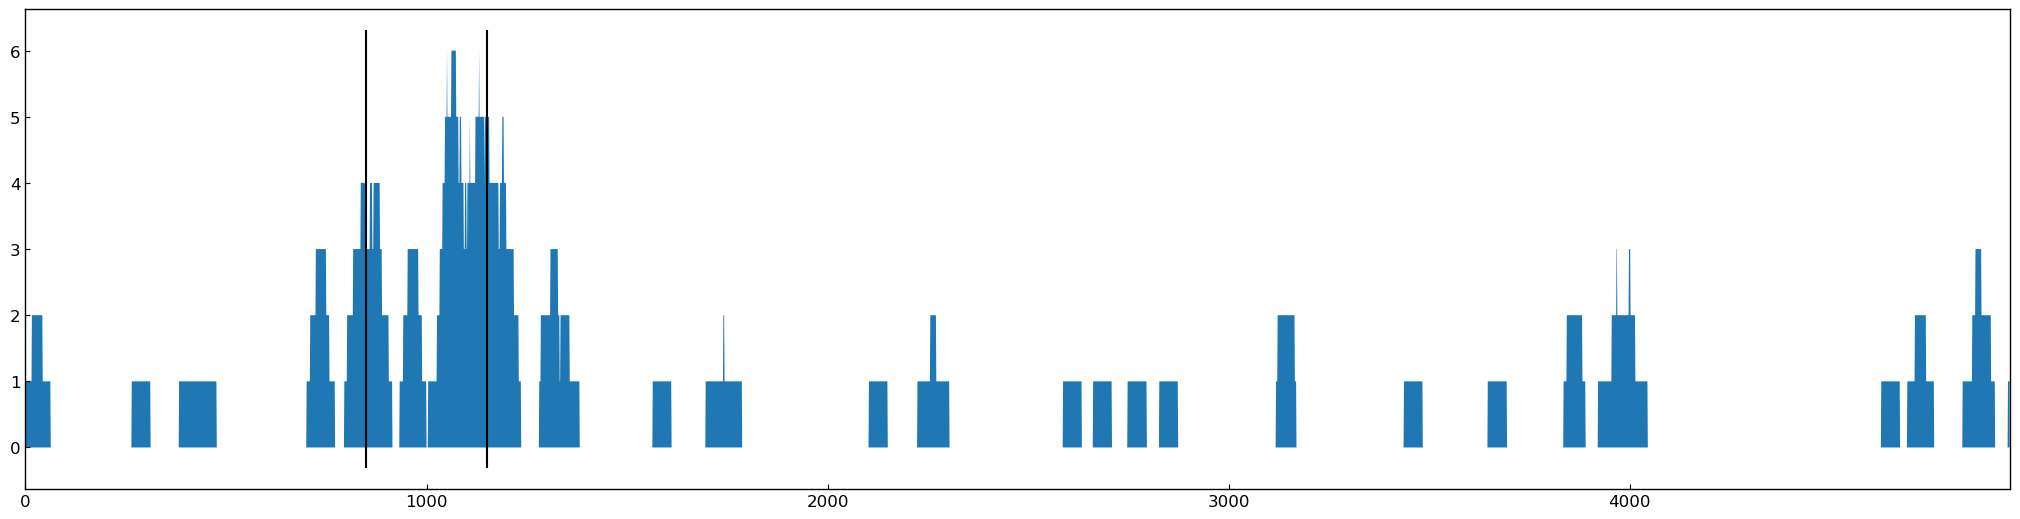

In [771]:
fig, ax = general_plot(dims=(20, 5))
# gc_bias = np.array(gc_fracs) - 0.5
# gc_bias_pos = gc_bias * (gc_bias > 0)
# gc_bias_neg = gc_bias * (gc_bias < 0)
ax.fill_between(
    np.arange(len(gc_quad)), np.zeros(len(gc_quad)), gc_quad
)

xlim = ax.get_xlim()
# ax.plot(xlim, [0, 0], "k")
ax.set_xlim(0,s_ont)
ylim = ax.get_ylim()
ax.plot([lines[0]]*2, ylim, 'k')
ax.plot([lines[1]]*2, ylim, 'k')

Get reads near ori

In [667]:
bam_fn = "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828_triple_oneline.bwa_multi.ont.bam"

samfile = pysam.AlignmentFile(bam_fn, "rb")


iter = samfile.fetch(contig_name, s_ont, s_ont + 650)

aln_names = []
for aln in iter:
    aln_names.append(aln.query_name)

aln_names

['76dedac7-609a-43dc-8d58-f7a6ef895220',
 'f0725bac-106c-4c8a-88f3-eba7813e3233',
 '057b6207-0d26-4c8d-9c7d-55a088c7c3f6',
 '191be210-5c67-447a-bfac-edb1c618217c',
 '179671f7-efa8-4718-a90d-4765784bc645',
 '789a85ed-1fd5-4716-91b3-a05fb5338eed',
 '97562360-74eb-48fd-82e4-a6b5ad3f8939;75fe0397-c11f-4494-a33e-0b4ef7b689d0',
 '97562360-74eb-48fd-82e4-a6b5ad3f8939',
 '75fe0397-c11f-4494-a33e-0b4ef7b689d0',
 'f4c303aa-f2e9-497d-9ea7-f80787775ad5',
 '0cdc4f0f-de18-438f-a283-2172f95567c3',
 'a9ba06f5-1433-4610-82fa-258b592c6a3e',
 'f2af29ee-1c51-4535-bdf2-ee6cd962377e',
 'c204101b-7c09-48bd-b863-3a1aa2bacc19',
 '4ec3c17c-011a-43de-aea5-5fce209e629a',
 '568effd6-fe8d-4a09-a388-7a9690a300eb',
 'c4a23fc6-2b0e-47cf-8fc0-82a56eea7d45',
 '4a3df9e0-5283-4679-a6c1-95f5eb686a67;4ec3c17c-011a-43de-aea5-5fce209e629a',
 '4a3df9e0-5283-4679-a6c1-95f5eb686a67',
 'e1f7a437-81ea-4860-990b-e02cc97ee1ac',
 'ee5cb4a1-ea2b-4b41-aa8b-fa94c475324a',
 'bf1ebfa7-17ab-46af-9f37-0838be17c87d',
 'ebfee647-46ca-4f6b-a0f

In [668]:
records = SeqIO.parse(ont_fastq, 'fastq')
ont_fastq = cluster + "/workdir/bmg224/manuscripts/mgefish/outputs/plasmids_metagenomic_analysis/nanopore/dorado/dorado_duplex.fastq"

records_aln = []
for r in records:
    if r.id in aln_names:
        records_aln.append(SeqRecord(r.seq, r.id))

records_aln

[SeqRecord(seq=Seq('AGTGTCCTGTACTTCGTTCGGTTGTAAGCCACCGATATTCACGGGAAAGTCCTT...TGA'), id='4baee93f-00ee-4ee6-a7e0-83ea668b7052', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('TTTGCTGGTCTGCTTCGTTGGGTATCCAGCCGGATATTCGCAAAGTCGCCTACC...GAC'), id='b41a0187-47ab-4055-a365-3e41f12a1e71', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('TTTTTTTTTTTTTTTTTTTTTTTTTTTTTAACCCGATTCCACAGCCCCCCAATT...GGG'), id='77466d9f-82f7-48d3-bac2-c9b2637b6bf1', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('GGTGTTATGTAGTCTACTGGTTGGTTATCAGGCCGGACCGATATTGGCAAGTCG...CAT'), id='6607b111-597a-4e34-9288-f740f18a742d', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('TTTGTCCTCTGCTTGGTTAAGGCGGGCGGCGGCTGGCGGGCGGGCGCATGGATG...TAG'), id='c204101b-7c09-48bd-b863-3a1aa2bacc19', name='<unknown name>', description='<unknown description>', dbxrefs=[]),


In [669]:
aln_fasta_fn = '../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828_sub_0_650_reads_aln.fasta'

SeqIO.write(records_aln, aln_fasta_fn, 'fasta')

65

In [659]:
dir(aln)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'aend',
 'alen',
 'aligned_pairs',
 'bin',
 'blocks',
 'cigar',
 'cigarstring',
 'cigartuples',
 'compare',
 'flag',
 'get_aligned_pairs',
 'get_blocks',
 'get_cigar_stats',
 'get_overlap',
 'get_reference_positions',
 'get_reference_sequence',
 'get_tag',
 'get_tags',
 'has_tag',
 'infer_query_length',
 'inferred_length',
 'is_duplicate',
 'is_paired',
 'is_proper_pair',
 'is_qcfail',
 'is_read1',
 'is_read2',
 'is_reverse',
 'is_secondary',
 'is_supplementary',
 'is_unmapped',
 'isize',
 'mapping_quality',
 'mapq',
 'mate_is_reverse',
 'mate_is_unmapped',
 'mpos',
 'mrnm',
 'next_reference_id',
 'n

bakta gene annotations

In [335]:
gff_fn = "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828_bakta/flye_contig_89828.gff3"
lines_contig = []
with open(gff_fn, "r") as f:
    lines = f.readlines()
    for l in lines:
        if l.startswith(contig_name):
            l_list = l.split("\t")
            # l_end = l_list[-1].split(';')
            # lines_contig.append(l_list[:-1] + l_end)
            lines_contig.append(l_list)

bakta_df = pd.DataFrame(lines_contig)
bakta_df.columns = [
    "contig",
    "method",
    "type",
    "start",
    "end",
    "dunno",
    "strand",
    "dunno2",
    "info",
]
bakta_df

,contig,method,type,start,end,dunno,strand,dunno2,info
0,contig_89828,Bakta,region,1,9865,.,+,.,ID=contig_89828;Name=contig_89828\n
1,contig_89828,Prodigal,CDS,158,775,.,-,0,ID=JHIOMJ_00005;Name=hypothetical protein;locu...
2,contig_89828,Prodigal,CDS,844,1407,.,-,0,ID=JHIOMJ_00010;Name=hypothetical protein;locu...
3,contig_89828,Prodigal,CDS,1586,2209,.,+,0,ID=JHIOMJ_00015;Name=Helix-turn-helix domain-c...
4,contig_89828,Prodigal,CDS,2305,4062,.,-,0,ID=JHIOMJ_00020;Name=MobA-MobL domain-containi...
5,contig_89828,Prodigal,CDS,4199,4468,.,+,0,ID=JHIOMJ_00025;Name=Mobilization protein;locu...
6,contig_89828,Prodigal,CDS,4472,4738,.,+,0,ID=JHIOMJ_00030;Name=Plasmid stabilization pro...
7,contig_89828,Prodigal,CDS,4728,5027,.,+,0,ID=JHIOMJ_00035;Name=Type II toxin-antitoxin s...
8,contig_89828,Prodigal,CDS,5106,5723,.,-,0,ID=JHIOMJ_00040;Name=hypothetical protein;locu...
9,contig_89828,Prodigal,CDS,5881,6624,.,-,0,ID=JHIOMJ_00045;Name=hypothetical protein;locu...


genomad annotatinos

In [374]:
genomad_fn = "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828_genomad/flye_contig_89828_summary/flye_contig_89828_plasmid_genes.tsv"
lines_contig = []
with open(genomad_fn, "r") as f:
    lines = f.readlines()
    for l in lines:
        if l.startswith(contig_name):
            l_list = l.split("\t")
            # l_end = l_list[-1].split(';')
            # lines_contig.append(l_list[:-1] + l_end)
            lines_contig.append(l_list)

genomad_df = pd.DataFrame(lines_contig)
genomad_df[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,contig_89828_1,2,79,78,1,0.667,11,None,NA,NA,NA,0,0,0,1,NA,NA,NA,NA,NA\n
1,contig_89828_2,158,775,618,-1,0.712,11,AGGAGG,GENOMAD.124016.PV,2.861e-37,141,0,1,0,1,NA,NA,NA,PF11740,Plasmid replication region DNA-binding N-term\n
2,contig_89828_3,844,1407,564,-1,0.706,11,None,NA,NA,NA,0,0,0,1,NA,NA,NA,NA,NA\n
3,contig_89828_4,1586,2209,624,1,0.603,11,GGAG/GAGG,GENOMAD.152162.PV,8.737e-53,186,0,0,0,1,NA,NA,NA,PF13730;COG5529;TIGR02812;K02565,Pyocin large subunit\n
4,contig_89828_5,2305,4062,1758,-1,0.712,11,GGA/GAG/AGG,GENOMAD.030790.PP,5.578e-32,136,0,0,0,1,NA,NA,NA,NA,NA\n
5,contig_89828_6,4199,4468,270,1,0.589,11,GGAG/GAGG,GENOMAD.048732.PP,2.046e-23,95,0,1,0,1,NA,NA,NA,PF12958,NA\n
6,contig_89828_7,4472,4738,267,1,0.607,11,AGGAG,GENOMAD.026258.PP,3.668e-40,143,0,0,0,1,NA,NA,NA,NA,NA\n
7,contig_89828_8,4728,5027,300,1,0.633,11,GGAG/GAGG,GENOMAD.213714.PC,3.758e-06,46,0,0,0,1,NA,NA,NA,PF05016;COG3668;TIGR02385,Plasmid stabilization system protein ParE\n
8,contig_89828_9,5106,5723,618,-1,0.712,11,AGGAGG,GENOMAD.124016.PV,2.861e-37,141,0,1,0,1,NA,NA,NA,PF11740,Plasmid replication region DNA-binding N-term\n
9,contig_89828_10,5881,6624,744,-1,0.649,11,None,NA,NA,NA,0,0,0,1,NA,NA,NA,NA,NA\n


Probe annotations

In [433]:
def get_blast_columns(include_seqs=False):
    blast_columns = [
        "qseqid",
        "sseqid",
        "pident",
        "qcovhsp",
        "length",
        "mismatch",
        "gapopen",
        "qstart",
        "qend",
        "sstart",
        "send",
        "sstrand",
        "evalue",
        "bitscore",
        "staxids",
    ]
    if include_seqs:
        blast_columns += ["qseq", "sseq"]
    return blast_columns


def read_blast_table(filename):
    blast_columns = get_blast_columns()
    # blast_columns = ['qseqid', 'sseqid', 'pident', 'qcovhsp', 'length', 'mismatch',
    #                 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'sstrand','evalue',
    #                 'bitscore', 'staxids', 'qseq', 'sseq']
    try:
        blast = pd.read_csv(filename, sep="\t", header=None)
        blast.columns = blast_columns
    except:
        blast = pd.DataFrame([], columns=blast_columns)
    return blast

In [434]:
blast_fn = "../opera_ms/genomad/plasmid_seqs/opera_contig_10048/flye_contig_89828.blast.probes.txt"

blast = read_blast_table(blast_fn)
blast

,qseqid,sseqid,pident,qcovhsp,length,mismatch,gapopen,qstart,qend,sstart,send,sstrand,evalue,bitscore,staxids
0,sp_B2.hsdm_7_01.1_184.L,contig_89828,100.0,48,19,0,0,1,19,2646,2628,minus,9.960000e-07,38.2,0
1,sp_B2.hsdm_7_01.1_184.R,contig_89828,100.0,48,19,0,0,22,40,2626,2608,minus,9.960000e-07,38.2,0
2,sp_B2.hsdm_7_01.1_225.L,contig_89828,100.0,48,19,0,0,1,19,2605,2587,minus,9.960000e-07,38.2,0
3,sp_B2.hsdm_7_01.1_225.R,contig_89828,100.0,48,19,0,0,22,40,2585,2567,minus,9.960000e-07,38.2,0
4,sp_B2.hsdm_7_01.1_79.L,contig_89828,100.0,48,19,0,0,1,19,2751,2733,minus,9.960000e-07,38.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,h.hsdm_7_01.3.453,contig_89828,100.0,94,16,0,0,2,17,611,626,plus,1.790000e-05,32.2,0
70,h.hsdm_7_01.3.110,contig_89828,100.0,100,17,0,0,1,17,267,283,plus,4.520000e-06,34.2,0
71,h.hsdm_7_01.3.283,contig_89828,100.0,100,15,0,0,1,15,440,454,plus,5.490000e-05,30.2,0
72,h.hsdm_7_01.4.325,contig_89828,100.0,100,24,0,0,1,24,1885,1862,minus,5.340000e-10,48.1,0


In [443]:
dict_probe_sepq = {}
for g, df_g in blast.groupby('qseqid'):
    val = 0
    for i, row in df_g.iterrows():
        if (row.sstart >= pos_range[0]) & (row.send <= pos_range[1]):  # check if inside the circular range
            val_ = row.pident + row.qcovhsp
            if val_ > val:  # Pick the alignment with the most pident and coverage combined
                val = val_
                sepq = [row.sstart, row.send, row.pident, row.qcovhsp]
    dict_probe_sepq[g] = sepq

dict_probe_sepq

{'h.hsdm_7_01.1.122': [2708, 2688, 100.0, 100],
 'h.hsdm_7_01.1.157': [2673, 2649, 100.0, 100],
 'h.hsdm_7_01.1.2': [2828, 2806, 100.0, 100],
 'h.hsdm_7_01.1.265': [2565, 2538, 100.0, 100],
 'h.hsdm_7_01.1.294': [2536, 2521, 100.0, 100],
 'h.hsdm_7_01.1.38': [2792, 2770, 100.0, 100],
 'h.hsdm_7_01.1.62': [2768, 2753, 100.0, 100],
 'h.hsdm_7_01.2.145': [4324, 4310, 100.0, 100],
 'h.hsdm_7_01.3.110': [267, 283, 100.0, 100],
 'h.hsdm_7_01.3.171': [328, 347, 100.0, 100],
 'h.hsdm_7_01.3.262': [419, 437, 100.0, 100],
 'h.hsdm_7_01.3.283': [440, 454, 100.0, 100],
 'h.hsdm_7_01.3.306': [463, 483, 100.0, 100],
 'h.hsdm_7_01.3.333': [490, 512, 100.0, 100],
 'h.hsdm_7_01.3.453': [611, 626, 100.0, 94],
 'h.hsdm_7_01.3.49': [206, 225, 100.0, 100],
 'h.hsdm_7_01.3.517': [674, 695, 100.0, 100],
 'h.hsdm_7_01.3.584': [741, 770, 100.0, 100],
 'h.hsdm_7_01.4.2': [2208, 2186, 100.0, 100],
 'h.hsdm_7_01.4.325': [1885, 1862, 100.0, 100],
 'sp_B2.hsdm_7_01.1_184.L': [2646, 2628, 100.0, 48],
 'sp_B2.hsdm_7_

In [444]:
# check if all probes are aligned
probes_fn = "/fs/cbsuvlaminck2/workdir/bmg224/manuscripts/mgefish/outputs/plasmids_metagenomic_analysis/hybrid_assembly/probe_design/outputs/opera_contig_10048/final_outputs/selection.fasta"

records = SeqIO.parse(probes_fn, 'fasta')
for r in records:
    print('Testing:',r.id)
    try:
        dict_probe_se[r.id]
    except:
        print('Missing alignemnt for:', r.id)

Testing: sp_B2.hsdm_7_01.1_184.L
Testing: sp_B2.hsdm_7_01.1_184.R
Testing: sp_B2.hsdm_7_01.1_225.L
Testing: sp_B2.hsdm_7_01.1_225.R
Testing: sp_B2.hsdm_7_01.1_79.L
Testing: sp_B2.hsdm_7_01.1_79.R
Testing: sp_B2.hsdm_7_01.2_19.L
Testing: sp_B2.hsdm_7_01.2_19.R
Testing: sp_B2.hsdm_7_01.2_59.L
Testing: sp_B2.hsdm_7_01.2_59.R
Testing: sp_B2.hsdm_7_01.2_104.L
Testing: sp_B2.hsdm_7_01.2_104.R
Testing: sp_B2.hsdm_7_01.2_162.L
Testing: sp_B2.hsdm_7_01.2_162.R
Testing: sp_B2.hsdm_7_01.3_471.L
Testing: sp_B2.hsdm_7_01.3_471.R
Testing: sp_B2.hsdm_7_01.3_205.L
Testing: sp_B2.hsdm_7_01.3_205.R
Testing: sp_B2.hsdm_7_01.3_9.L
Testing: sp_B2.hsdm_7_01.3_9.R
Testing: sp_B2.hsdm_7_01.3_413.L
Testing: sp_B2.hsdm_7_01.3_413.R
Testing: sp_B2.hsdm_7_01.3_364.L
Testing: sp_B2.hsdm_7_01.3_364.R
Testing: sp_B2.hsdm_7_01.3_70.L
Testing: sp_B2.hsdm_7_01.3_70.R
Testing: sp_B2.hsdm_7_01.3_129.L
Testing: sp_B2.hsdm_7_01.3_129.R
Testing: sp_B2.hsdm_7_01.3_545.L
Testing: sp_B2.hsdm_7_01.3_545.R
Testing: sp_B2.hsdm_7_

## Circular plot

Manually curate annotations

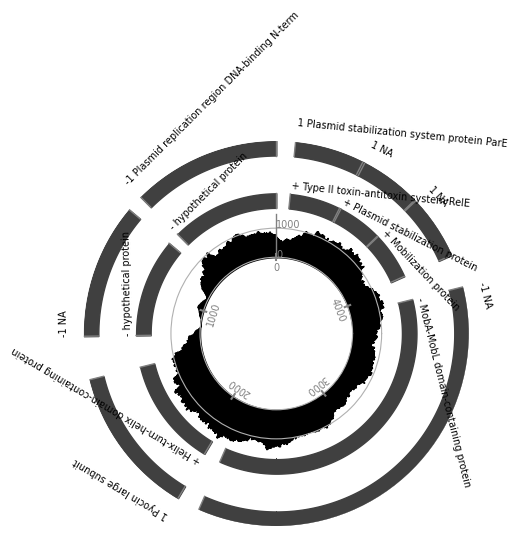

In [447]:
adj = 3
ft = 7
dims = (5, 5)
lw = 1

r = coverage_sub
rmean = np.mean(r)
r_base = rmean * adj
r_adj = r + r_base
r_max = np.max(r_adj)
r_bases = [r_base] * len(r)
pmin = np.min(positions_sub)
pmax = np.max(positions_sub)
p_norm = (np.array(positions_sub) - pmin) / (pmax - pmin)
theta = 2 * np.pi * p_norm + (np.pi / 2)

fig, ax = plt.subplots(figsize=dims, subplot_kw={"projection": "polar"})
ax.fill_between(theta, r_bases, r_adj, color="k")

rticks = np.arange(r_base, np.max(r_adj), 1000)
rtick_labels = rticks - r_base
ax.set_rticks(rticks, labels=[])  # Less radial ticks


# ax.set_xticks(theta_ticks, labels=pos_ticks)
ax.set_xticks([])
# ax.tick_params(axis="x", which="major", pad=-15)
ax.xaxis.grid(False)
ax.spines["polar"].set_visible(False)

gray = np.array([1, 1, 1]) * 0.5

rlab_pos = np.pi / 2
rot = (rlab_pos - (np.pi / 2)) * (180 / np.pi)
for r, rl in zip(rticks, rtick_labels):
    ax.text(
        rlab_pos, r, int(rl), color=gray, rotation=rot, rotation_mode="anchor", size=ft
    )
ax.plot([rlab_pos] * 2, [r_base, r_max], color=gray, lw=lw)
# ax.set_rlabel_position(r)

r_offset = 200
rticklen = 100
pos_max = np.max(positions_sub)
pos_ticks = np.arange(0, pos_max, 1000)
theta_ticks = pos_ticks / pos_max * 2 * np.pi + (np.pi / 2)
for t, p in zip(theta_ticks, pos_ticks):
    #     rot = (t - np.pi) if (t > np.pi/2) & (t < 3*np.pi/4) else t
    #     rot *= (180 / np.pi)
    rot = (t - np.pi / 2) * (180 / np.pi)
    ax.text(
        t,
        r_base - r_offset,
        int(p),
        ha="center",
        va="top",
        color=gray,
        rotation=rot,
        rotation_mode="anchor",
        size=ft,
    )
    ax.plot([t] * 2, [r_base - rticklen, r_base + rticklen], color=gray)

## bakta annotations
bakta_offset = 200
bar_width = 500
batka_lab_displace = 100
bar_color = np.ones(3) * 0.25
for i, row in bakta_df[1:].iterrows():
    start, end = sorted([int(s) for s in [row["start"], row["end"]]])
    if (start >= pos_range[0]) & (end <= pos_range[1]):
        # bar
        pos_se = np.arange(start, end)
        theta_se = 2 * np.pi * (pos_se - pos_range[0]) / pmax + (np.pi / 2)
        r0 = np.array([r_max + batka_offset] * len(theta_se))
        r1 = r0 + bar_width
        ax.fill_between(theta_se, r0, r1, color=bar_color)

        # end lines
        ax.plot([theta_se[0]] * 2, [r0[0], r1[0]], color=gray, lw=lw)
        ax.plot([theta_se[-1]] * 2, [r0[-1], r1[-1]], color=gray, lw=lw)

        # Label
        eth = theta_se[-1]
        rot = (eth - np.pi / 2) * (180 / np.pi)
        name = re.findall("(?<=Name=)[a-zA-Z0-9\s\-]+", row["info"])[0]
        ax.text(
            theta_se[-1],
            r1[0] + batka_lab_displace,
            row["strand"] + " " + name,
            fontsize=ft,
            rotation=rot,
            ha="left",
            va="bottom",
            rotation_mode="anchor",
        )


## bakta annotations
genomad_offset = 2000
bar_width = 500
genomad_lab_displace = 100
bar_color = np.ones(3) * 0.25
for i, row in genomad_df[1:].iterrows():
    start, end = sorted([int(s) for s in [row[1], row[2]]])
    if (start >= pos_range[0]) & (end <= pos_range[1]):
        # bar
        pos_se = np.arange(start, end)
        theta_se = 2 * np.pi * (pos_se - pos_range[0]) / pmax + (np.pi / 2)
        r0 = np.array([r_max + genomad_offset] * len(theta_se))
        r1 = r0 + bar_width
        ax.fill_between(theta_se, r0, r1, color=bar_color)

        # end lines
        ax.plot([theta_se[0]] * 2, [r0[0], r1[0]], color=gray, lw=lw)
        ax.plot([theta_se[-1]] * 2, [r0[-1], r1[-1]], color=gray, lw=lw)

        # Label
        eth = theta_se[-1]
        rot = (eth - np.pi / 2) * (180 / np.pi)
        name = row[19]
        ax.text(
            theta_se[-1],
            r1[0] + genomad_lab_displace,
            row[4] + " " + name,
            fontsize=ft,
            rotation=rot,
            ha="left",
            va="bottom",
            rotation_mode="anchor",
        )

ax.set_ylim(0, r1[0])

# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True)

# ax.set_title("A line plot on a polar axis", va="bottom")
plt.show()

In [378]:
annotations = {
    "- Plasmid replication region DNA-binding N-term": [158, 775],
    "- hypothetical protein": [844, 1407],
    "+ Pyocin large subunit": [1586, 2209],
    "- MobA-MobL domain-containing protein": [2305, 4062],
    "+ Mobilization protein": [4199, 4468],
    "+ Plasmid stabilization protein": [4472, 4738],
    "+ Type II toxin-antitoxin system RelE/ParE family toxin": [4728, 5027]
}

Final plot

In [595]:
np.max(r0_gc + r_gc_pos), np.max(r0_gc)

(6710.346051567885, 6447.188156831043)

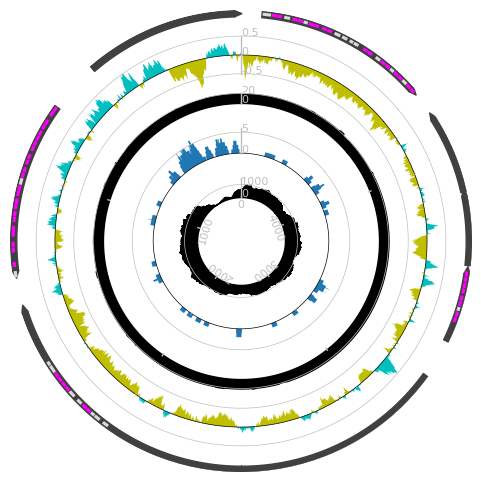

In [826]:
adj = 4
ft = 8
dims = (6,6)
lw = 1

gray = np.array([1, 1, 1]) * 0.75
rotation_offset = np.pi / 4.5

## Short read
r = coverage_sub
rmean = np.mean(r)
r_base = rmean * adj
r_adj = r + r_base
r_max = np.max(r_adj)
r_bases = [r_base] * len(r)
pmin = np.min(positions_sub)
pmax = np.max(positions_sub)
p_norm = (np.array(positions_sub) - pmin) / (pmax - pmin)
theta = 2 * np.pi * p_norm + rotation_offset

# plot
fig, ax = plt.subplots(figsize=dims, subplot_kw={"projection": "polar"})
ax.fill_between(theta, r_bases, r_adj, color="k")

# R ticks
rticks = np.arange(r_base, np.max(r_adj), 1000)
for r in rticks[1:]:
    rt = [r]*len(theta)
    ax.plot(theta, rt, color=gray, lw=lw*0.5)

# R labels
rtick_labels = rticks - r_base
rlab_pos = np.pi / 2
rot = (rlab_pos - (np.pi / 2)) * (180 / np.pi)
for r, rl in zip(rticks, rtick_labels):
    ax.text(
        rlab_pos, r, int(rl), color=gray, rotation=rot, rotation_mode="anchor", size=ft
    )
ax.plot([rlab_pos] * 2, [r_base, r_max], color=gray, lw=lw)



## quad GC
quad_offset = 2000
quad_width = 2000
color_quad = 'tab:blue'
quad_top_tick = 5
# data
r_base_quad = np.array([r_max + quad_offset] * len(theta))
r_quad = (gc_quad / np.max(gc_quad)) * quad_width
r_quad_adj = r_base_quad + r_quad
r_max_quad = np.max(r_quad_adj)
ax.fill_between(theta, r_base_quad, r_quad_adj, facecolor=color_quad, edgecolor=None)
# Rticks
ax.plot(theta, r_base_quad, color='k', lw=lw*0.5)
quad_top_rtick = quad_top_tick / np.max(gc_quad) * quad_width
quad_top_rtick_adj = np.array([quad_top_rtick]*len(theta)) + r_base_quad
ax.plot(theta, quad_top_rtick_adj, color=gray, lw=lw*0.5)
# Rtick labels
rticks_quad = [r_base_quad[0], quad_top_rtick_adj[0]]
rtick_labels_quad = [0,quad_top_tick]
for r, rl in zip(rticks_quad, rtick_labels_quad):
    ax.text(
        rlab_pos, r, int(rl), color=gray, rotation=rot, rotation_mode="anchor", size=ft
    )
ax.plot([rlab_pos] * 2, [r_base_quad[0], r_max_quad], color=gray, lw=lw)



## long read
ont_top_rtick = 20
ont_scaler = 750
ont_factor = ont_scaler / ont_top_rtick
ont_offset = 2000
r_ont = coverage_ont_sub * ont_factor
rmean_ont = np.mean(r_ont)
r_base_ont = r_max_quad + ont_offset
r_adj_ont = r_ont + r_base_ont
r_max_ont = np.max(r_adj_ont)
r_bases_ont = [r_base_ont] * len(r_ont)
pmin_ont = np.min(positions_ont_sub)
pmax_ont = np.max(positions_sub)
p_norm_ont = (np.array(positions_ont_sub) - pmin_ont) / (pmax_ont - pmin_ont)
theta_ont = 2 * np.pi * p_norm_ont + rotation_offset

# plot ont
ax.fill_between(theta_ont, r_bases_ont, r_adj_ont, color="k")

# R ticks ont
rticks_ont = np.arange(r_base_ont, np.max(r_adj_ont), ont_scaler)
for r in rticks_ont[1:]:
    rt = [r]*len(theta_ont)
    ax.plot(theta_ont, rt, color=gray, lw=lw*0.5)

# R labels ont
rtick_labels_ont = (rticks_ont - r_base_ont) / ont_factor
for r, rl in zip(rticks_ont, rtick_labels_ont):
    ax.text(
        rlab_pos, r, int(rl), color=gray, rotation=rot, rotation_mode="anchor", size=ft
    )
ax.plot([rlab_pos] * 2, [r_base_ont, r_max_ont], color=gray, lw=lw)



## GC skew
gc_offset = 3000
gc_width = 3000
color_gc_pos = 'c'
# color_gc_pos = np.ones(3) * 0.8
color_gc_neg = 'y'
# color_gc_neg = np.ones(3) * 0.75
# Data
r0_gc = np.array([r_max_ont + gc_offset] * len(theta))
r_gc_pos = gc_skew_pos * gc_width
r_gc_neg = gc_skew_neg * gc_width
r_gc_pos_adj = r0_gc + r_gc_pos
r_gc_neg_adj = r0_gc + r_gc_neg
r_max_gc = np.max(r_gc_pos_adj)
ax.fill_between(theta, r0_gc, r_gc_pos_adj, facecolor=color_gc_pos, edgecolor=None)
ax.fill_between(theta, r_gc_neg_adj, r0_gc, facecolor=color_gc_neg, edgecolor=None)
# R ticks
rticks_gc = [r0_gc[0] - gc_width / 2, r0_gc[0], r0_gc[0] + gc_width / 2]
ax.plot(theta, r0_gc, color='k', lw=lw*0.5)
ax.plot(theta, [rticks_gc[0]]*len(theta), color=gray, lw=lw*0.5)
ax.plot(theta, [rticks_gc[-1]]*len(theta), color=gray, lw=lw*0.5)
# R labels 
rtick_labels_gc = [-0.5, 0, 0.5]
for r, rl in zip(rticks_gc, rtick_labels_gc):
    ax.text(
        rlab_pos, r, rl, color=gray, rotation=rot, rotation_mode="anchor", size=ft
    )
ax.plot([rlab_pos] * 2, [rticks_gc[0], rticks_gc[-1]], color=gray, lw=lw)




## manipulate axes
# plot rticks
# rticks_fin = np.hstack([rticks, rticks_ont])
# ax.set_rticks(rticks_fin, labels=[])  # Less radial ticks

# remove axes
ax.set_xticks([])
ax.set_rticks([])
ax.xaxis.grid(False)
ax.spines["polar"].set_visible(False)


# θ labels
r_offset = 200
rticklen = 100
pos_max = np.max(positions_sub)
pos_ticks = np.arange(0, pos_max, 1000)
theta_ticks = pos_ticks / pos_max * 2 * np.pi + (np.pi / 2)
for t, p in zip(theta_ticks, pos_ticks):
    #     rot = (t - np.pi) if (t > np.pi/2) & (t < 3*np.pi/4) else t
    #     rot *= (180 / np.pi)
    rot = (t - np.pi / 2) * (180 / np.pi)
    ax.text(
        t,
        r_base - r_offset,
        int(p),
        ha="center",
        va="top",
        color=gray,
        rotation=rot,
        rotation_mode="anchor",
        size=ft,
    )
    ax.plot([t] * 2, [r_base - rticklen, r_base + rticklen], color=gray, lw=lw)
    ax.plot([t] * 2, [r_base_quad[0] - rticklen, r_base_quad[0] + rticklen], color=gray, lw=lw*0.5)
    ax.plot([t] * 2, [r_base_ont - rticklen, r_base_ont + rticklen], color=gray, lw=lw)
    ax.plot([t] * 2, [r0_gc[0] - rticklen, r0_gc[0] + rticklen], color=gray, lw=lw*0.5)
    # ax.plot([t] * 2, [r_base_quad - rticklen, r_base_quad + rticklen], color=gray, lw=lw)




##  annotations
bakta_offset = 1500
bar_width = 500
bakta_lab_displace = 100
bar_color = np.ones(3) * 0.25
arrow_length = 25
for name, [start, end] in annotations.items():
    start, end = sorted([int(s) for s in [start, end]])
    if (start >= pos_range[0]) & (end <= pos_range[1]):
        # bar
        orient = name[0]
        if orient == "+":
            end_new = end - arrow_length
            pos_se = np.arange(start, end_new)
        elif orient == "-":
            start_new = start + arrow_length
            pos_se = np.arange(start_new, end)
        theta_se = 2 * np.pi * (pos_se - pos_range[0]) / pmax + rotation_offset
        r0 = np.array([r_max_gc + bakta_offset] * len(theta_se))
        r1 = r0 + bar_width
        ax.fill_between(theta_se, r0, r1, color=bar_color)

        # # arrow
        rmid = np.mean([r0[0], r1[0]])
        if orient == "+":
            arrow_se = np.array([end_new, end])
            arrow_rs = [[r0[0], rmid], [r1[0], rmid]]
            # arrow_len_theta = 2 * np.pi * arrow_length / pmax + (np.pi / 2)
            # theta_arrow_e = theta_se[-1] + arrow_len_theta
        elif orient == "-":
            arrow_se = np.array([start, start_new])
            arrow_rs = [[rmid, r0[0]], [rmid, r1[0]]]
        theta_arrow_se = 2 * np.pi * (arrow_se - pos_range[0]) / pmax + rotation_offset
        ax.fill_between(theta_arrow_se, arrow_rs[0], arrow_rs[1], color=bar_color)
        # end lines
        # ax.plot([theta_se[0]] * 2, [r0[0], r1[0]], color=gray, lw=lw)
        # ax.plot([theta_se[-1]] * 2, [r0[-1], r1[-1]], color=gray, lw=lw)

        # Label
        eth = theta_se[-1]
        rot = (eth - np.pi / 3) * (180 / np.pi)
        # name = re.findall("(?<=Name=)[a-zA-Z0-9\s\-]+", row["info"])[0]
        # ax.text(
        #     theta_se[-1],
        #     r1[0] + bakta_lab_displace,
        #     name,
        #     fontsize=ft,
        #     rotation=rot,
        #     ha="left",
        #     va="bottom",
        #     rotation_mode="anchor",
        # )


## Probes
probe_color = (1, 0, 1)
helper_color = np.ones(3) * 0.85
probe_width = 250 
for probe, sepq in dict_probe_sepq.items():
    pos_se = np.sort([sepq[0], sepq[1]])
    theta_se = 2 * np.pi * (pos_se - pos_range[0]) / pmax + rotation_offset

    r0_p = np.array([rmid - probe_width/2] * len(theta_se))
    r1_p = r0_p + probe_width

    color = probe_color if probe[:2] == "sp" else helper_color
    ax.fill_between(theta_se, r0_p, r1_p, facecolor=color, edgecolor=None)

    # end lines
    # color_el = bar_color
    # el_lw = lw * 0.1
    # ax.plot([theta_se[0]] * 2, [r0[0], r1[0]], color=color_el, lw=el_lw)
    # ax.plot([theta_se[-1]] * 2, [r0[-1], r1[-1]], color=color_el, lw=el_lw)

ax.set_ylim(0, r1[0])

# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True)

# ax.set_title("A line plot on a polar axis", va="bottom")

out_bn = "/fs/cbsuvlaminck2/workdir/bmg224/manuscripts/mgefish/outputs/plasmids_metagenomic_analysis/hybrid_assembly/probe_design/outputs/opera_contig_10048/final_outputs/circular_plot_gc"
save_png_pdf(out_bn)

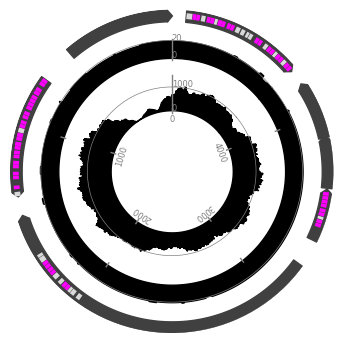

In [833]:
adj = 3
ft = 6
dims = (4.2, 4.2)
lw = 1

gray = np.array([1, 1, 1]) * 0.5
rotation_offset = np.pi / 4.5
rlab_pos = np.pi / 2
rot = (rlab_pos - (np.pi / 2)) * (180 / np.pi)

## Short read
r = coverage_sub
rmean = np.mean(r)
r_base = rmean * adj
r_adj = r + r_base
r_max = np.max(r_adj)
r_bases = [r_base] * len(r)
pmin = np.min(positions_sub)
pmax = np.max(positions_sub)
p_norm = (np.array(positions_sub) - pmin) / (pmax - pmin)
theta = 2 * np.pi * p_norm + rotation_offset

# plot
fig, ax = plt.subplots(figsize=dims, subplot_kw={"projection": "polar"})
ax.fill_between(theta, r_bases, r_adj, color="k")

# R ticks
rticks = np.arange(r_base, np.max(r_adj), 1000)
for r in rticks[1:]:
    rt = [r]*len(theta)
    ax.plot(theta, rt, color=gray, lw=lw*0.5)

# R labels
rtick_labels = rticks - r_base

for r, rl in zip(rticks, rtick_labels):
    ax.text(
        rlab_pos, r, int(rl), color=gray, rotation=rot, rotation_mode="anchor", size=ft
    )
ax.plot([rlab_pos] * 2, [r_base, r_max], color=gray, lw=lw)



## quad GC
quad_offset = 750
quad_width = 750
color_quad = 'tab:blue'
quad_top_tick = 5
# data
r_base_quad = np.array([r_max + quad_offset] * len(theta))
r_quad = (gc_quad / np.max(gc_quad)) * quad_width
r_quad_adj = r_base_quad + r_quad
r_max_quad = np.max(r_quad_adj)
# ax.fill_between(theta, r_base_quad, r_quad_adj, facecolor=color_quad, edgecolor=None)
# # Rticks
# ax.plot(theta, r_base_quad, color='k', lw=lw*0.5)
# quad_top_rtick = quad_top_tick / np.max(gc_quad) * quad_width
# quad_top_rtick_adj = np.array([quad_top_rtick]*len(theta)) + r_base_quad
# ax.plot(theta, quad_top_rtick_adj, color=gray, lw=lw*0.5)
# # Rtick labels
# rticks_quad = [r_base_quad[0], quad_top_rtick_adj[0]]
# rtick_labels_quad = [0,quad_top_tick]
# for r, rl in zip(rticks_quad, rtick_labels_quad):
#     ax.text(
#         rlab_pos, r, int(rl), color=gray, rotation=rot, rotation_mode="anchor", size=ft
#     )
# ax.plot([rlab_pos] * 2, [r_base_quad[0], r_max_quad], color=gray, lw=lw)



## long read
ont_top_rtick = 20
ont_scaler = 750
ont_factor = ont_scaler / ont_top_rtick
ont_offset = 750
r_ont = coverage_ont_sub * ont_factor
rmean_ont = np.mean(r_ont)
r_base_ont = r_max + ont_offset
r_adj_ont = r_ont + r_base_ont
r_max_ont = np.max(r_adj_ont)
r_bases_ont = [r_base_ont] * len(r_ont)
pmin_ont = np.min(positions_ont_sub)
pmax_ont = np.max(positions_sub)
p_norm_ont = (np.array(positions_ont_sub) - pmin_ont) / (pmax_ont - pmin_ont)
theta_ont = 2 * np.pi * p_norm_ont + rotation_offset

# plot ont
ax.fill_between(theta_ont, r_bases_ont, r_adj_ont, color="k")

# R ticks ont
rticks_ont = np.arange(r_base_ont, np.max(r_adj_ont), ont_scaler)
for r in rticks_ont[1:]:
    rt = [r]*len(theta_ont)
    ax.plot(theta_ont, rt, color=gray, lw=lw*0.5)

# R labels ont
rtick_labels_ont = (rticks_ont - r_base_ont) / ont_factor
for r, rl in zip(rticks_ont, rtick_labels_ont):
    ax.text(
        rlab_pos, r, int(rl), color=gray, rotation=rot, rotation_mode="anchor", size=ft
    )
ax.plot([rlab_pos] * 2, [r_base_ont, r_max_ont], color=gray, lw=lw)



## GC skew
gc_offset = 1500
gc_width = 1000
color_gc_pos = 'c'
# color_gc_pos = np.ones(3) * 0.8
color_gc_neg = 'y'
# color_gc_neg = np.ones(3) * 0.75
# Data
r0_gc = np.array([r_max_ont + gc_offset] * len(theta))
r_gc_pos = gc_skew_pos * gc_width
r_gc_neg = gc_skew_neg * gc_width
r_gc_pos_adj = r0_gc + r_gc_pos
r_gc_neg_adj = r0_gc + r_gc_neg
r_max_gc = np.max(r_gc_pos_adj)
# ax.fill_between(theta, r0_gc, r_gc_pos_adj, facecolor=color_gc_pos, edgecolor=None)
# ax.fill_between(theta, r_gc_neg_adj, r0_gc, facecolor=color_gc_neg, edgecolor=None)
# # R ticks
# ax.plot(theta, r0_gc, color='k', lw=lw*0.5)
# # R labels 
# rticks_gc = [r0_gc[0] - gc_width / 2, r0_gc[0], r0_gc[0] + gc_width / 2]
# rtick_labels_gc = [-0.5, 0, 0.5]
# for r, rl in zip(rticks_gc, rtick_labels_gc):
#     ax.text(
#         rlab_pos, r, rl, color=gray, rotation=rot, rotation_mode="anchor", size=ft
#     )
# ax.plot([rlab_pos] * 2, [rticks_gc[0], rticks_gc[-1]], color=gray, lw=lw)




## manipulate axes
# plot rticks
# rticks_fin = np.hstack([rticks, rticks_ont])
# ax.set_rticks(rticks_fin, labels=[])  # Less radial ticks

# remove axes
ax.set_xticks([])
ax.set_rticks([])
ax.xaxis.grid(False)
ax.spines["polar"].set_visible(False)


# θ labels
r_offset = 200
rticklen = 100
pos_max = np.max(positions_sub)
pos_ticks = np.arange(0, pos_max, 1000)
theta_ticks = pos_ticks / pos_max * 2 * np.pi + (np.pi / 2)
for t, p in zip(theta_ticks, pos_ticks):
    #     rot = (t - np.pi) if (t > np.pi/2) & (t < 3*np.pi/4) else t
    #     rot *= (180 / np.pi)
    rot = (t - np.pi / 2) * (180 / np.pi)
    ax.text(
        t,
        r_base - r_offset,
        int(p),
        ha="center",
        va="top",
        color=gray,
        rotation=rot,
        rotation_mode="anchor",
        size=ft,
    )
    ax.plot([t] * 2, [r_base - rticklen, r_base + rticklen], color=gray, lw=lw)
    ax.plot([t] * 2, [r_base_ont - rticklen, r_base_ont + rticklen], color=gray, lw=lw)
    # ax.plot([t] * 2, [r_base_quad[0] - rticklen, r_base_quad[0] + rticklen], color=gray, lw=lw)
    # ax.plot([t] * 2, [r0_gc[0] - rticklen, r0_gc[0] + rticklen], color=gray, lw=lw)
    # ax.plot([t] * 2, [r_base_quad - rticklen, r_base_quad + rticklen], color=gray, lw=lw)




##  annotations
bakta_offset = 750
bar_width = 500
bakta_lab_displace = 100
bar_color = np.ones(3) * 0.25
arrow_length = 25
for name, [start, end] in annotations.items():
    start, end = sorted([int(s) for s in [start, end]])
    if (start >= pos_range[0]) & (end <= pos_range[1]):
        # bar
        orient = name[0]
        if orient == "+":
            end_new = end - arrow_length
            pos_se = np.arange(start, end_new)
        elif orient == "-":
            start_new = start + arrow_length
            pos_se = np.arange(start_new, end)
        theta_se = 2 * np.pi * (pos_se - pos_range[0]) / pmax + rotation_offset
        r0 = np.array([r_max_ont + bakta_offset] * len(theta_se))
        r1 = r0 + bar_width
        ax.fill_between(theta_se, r0, r1, color=bar_color)

        # # arrow
        rmid = np.mean([r0[0], r1[0]])
        if orient == "+":
            arrow_se = np.array([end_new, end])
            arrow_rs = [[r0[0], rmid], [r1[0], rmid]]
            # arrow_len_theta = 2 * np.pi * arrow_length / pmax + (np.pi / 2)
            # theta_arrow_e = theta_se[-1] + arrow_len_theta
        elif orient == "-":
            arrow_se = np.array([start, start_new])
            arrow_rs = [[rmid, r0[0]], [rmid, r1[0]]]
        theta_arrow_se = 2 * np.pi * (arrow_se - pos_range[0]) / pmax + rotation_offset
        ax.fill_between(theta_arrow_se, arrow_rs[0], arrow_rs[1], color=bar_color)
        # end lines
        # ax.plot([theta_se[0]] * 2, [r0[0], r1[0]], color=gray, lw=lw)
        # ax.plot([theta_se[-1]] * 2, [r0[-1], r1[-1]], color=gray, lw=lw)

        # Label
        eth = theta_se[-1]
        rot = (eth - np.pi / 3) * (180 / np.pi)
        # name = re.findall("(?<=Name=)[a-zA-Z0-9\s\-]+", row["info"])[0]
        # ax.text(
        #     theta_se[-1],
        #     r1[0] + bakta_lab_displace,
        #     name,
        #     fontsize=ft,
        #     rotation=rot,
        #     ha="left",
        #     va="bottom",
        #     rotation_mode="anchor",
        # )


## Probes
probe_color = (1, 0, 1)
helper_color = np.ones(3) * 0.85
probe_width = 250 
for probe, sepq in dict_probe_sepq.items():
    pos_se = np.sort([sepq[0], sepq[1]])
    theta_se = 2 * np.pi * (pos_se - pos_range[0]) / pmax + rotation_offset

    r0_p = np.array([rmid - probe_width/2] * len(theta_se))
    r1_p = r0_p + probe_width

    color = probe_color if probe[:2] == "sp" else helper_color
    ax.fill_between(theta_se, r0_p, r1_p, facecolor=color, edgecolor=None)

    # end lines
    # color_el = bar_color
    # el_lw = lw * 0.1
    # ax.plot([theta_se[0]] * 2, [r0[0], r1[0]], color=color_el, lw=el_lw)
    # ax.plot([theta_se[-1]] * 2, [r0[-1], r1[-1]], color=color_el, lw=el_lw)

ax.set_ylim(0, r1[0])

# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True)

# ax.set_title("A line plot on a polar axis", va="bottom")

out_bn = "/fs/cbsuvlaminck2/workdir/bmg224/manuscripts/mgefish/outputs/plasmids_metagenomic_analysis/hybrid_assembly/probe_design/outputs/opera_contig_10048/final_outputs/circular_plot"
save_png_pdf(out_bn)

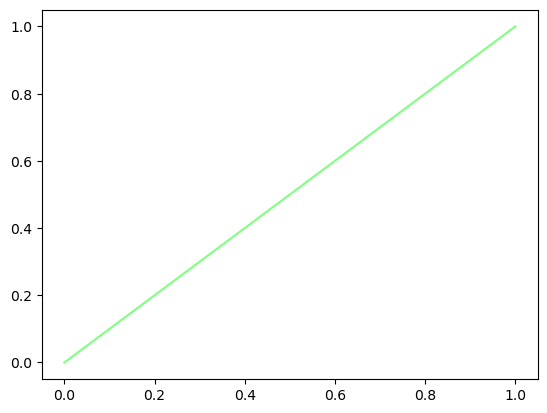

In [773]:
plt.plot([0,1], [0,1], color=[0.5,1,0.5])